# BML Project: Airline Delay Time Series Analysis

## Introduction

### Motivation

As the holidays approach, we are interested informing travelers of the risk of travel delays that
would add to an already stressful season. By analyzing airline travel delays, we hope to gain insight on factors contributing to delays and guide travelers on how best to anticipate delays.

### Goals
Our goals for this project are to 
1) Analyze trends in airline delays over time
2) Predict the number of flight delays in a given time period
3) Evaluate uncertainty in model predictions.

### Data
The data are from Kaggle and consist of 27 variables: https://www.kaggle.com/datasets/sherrytp/airline-delay-analysis

### Approach

We propose using Bayesian statistics with ADVI and will investigate:
* Various logistic regression models to predict whetheror not a given flight will be delayed.

## Code

### Package control

In [329]:
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import math
import xarray as xr
from scipy import stats
from ydata_profiling import ProfileReport
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from patsy import bs, dmatrix
from cycler import cycler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json
import statsmodels.api as sm
from scipy import stats
import scipy.fftpack
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pytensor.tensor as pt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import gc
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Helper function for adding minutes to hhmm formated integers
# this is useful for the difference in some of the time formatted columns
def subtract_minutes_from_integer_time(time_int, minutes_to_subtract):
    hours = time_int // 100
    minutes = time_int % 100
    total_minutes = hours * 60 + minutes - minutes_to_subtract  # Subtracting minutes
    updated_hours = total_minutes // 60
    updated_minutes = total_minutes % 60
    updated_hours %= 24
    return updated_hours * 100 + updated_minutes

### Data dictionary

**NOTE times are local but this works for us. We will need to explain this further**

Reference: https://www.transtats.bts.gov/Fields.asp?P74_e19=EDD&P74_P1y=&n22yB_4n6r=&5146_p1y7z0=&frn4pu_Y11x72=&sv0q=&5146_14qr4=
* FL_DATE: Date of flight

* OP_CARRIER: Abbreviation of carrier

* OP_CARRIER_FL_NUM: Carrier flight number

* ORIGIN: Origin airport code

* DEST: Destination airport code

* CRS_DEP_TIME: CRS (scheduled) departure time (local time: hhmm)

* DEP_TIME: Actual departure time (local time: hhmm)

* DEP_DELAY: Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

* TAXI_OUT: Taxi Out Time, in Minutes

* WHEELS_OFF: Wheels Off Time (local time: hhmm)

* WHEELS_ON: Wheels On Time (local time: hhmm)

* TAXI_IN: Taxi In Time, in Minutes

* CRS_ARR_TIME: CRS (scheduled) Arrival Time (local time: hhmm)

* ARR_TIME: Actual Arrival Time (local time: hhmm)

* ARR_DELAY: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.

* CANCELLED: Cancelled Flight Indicator (1=Yes)

* CANCELLATION_CODE: Reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

* DIVERTED: Diverted Flight Indicator (1=Yes)

* CRS_ELAPSED_TIME: CRS (scheduled) Elapsed Time of Flight, in Minutes

* ACTUAL_ELAPSED_TIME: Elapsed Time of Flight, in Minutes

* AIR_TIME: Flight Time, in Minutes

* DISTANCE: Distance between airports (miles)

* CARRIER_DELAY: Carrier Delay, in Minutes

* WEATHER_DELAY: Weather Delay, in Minutes

* NAS_DELAY: National Air System Delay, in Minutes

* SECURITY_DELAY: Security Delay, ft Delay, in Minutes

* Unnamed: 27: Unused

### Data Load

In [330]:
# There is so much data...let's only choose the past few years to start
data_2015 = pd.read_csv('data_files/2015.csv')
data_2016 = pd.read_csv('data_files/2016.csv')
data_2017 = pd.read_csv('data_files/2017.csv')
data_2018 = pd.read_csv('data_files/2018.csv')
data_2019 = pd.read_csv('data_files/2019.csv')

### Data cleaning and EDA

#### Data wrangling

In [331]:
# List of dataframes for ease of access
data_years = [data_2015, data_2016, data_2017, data_2018, data_2019]

In [332]:
# Check dataframe shapes
for i, j in zip(data_years, range(2015,2020)): print(f'Shape of {j}_data is {i.shape}')

Shape of 2015_data is (5819079, 28)
Shape of 2016_data is (5617658, 28)
Shape of 2017_data is (5674621, 28)
Shape of 2018_data is (7213446, 28)
Shape of 2019_data is (7422037, 21)


It seems like 2019 has a different number of columns than expected. Let's see what each year's columns are like. We'll start with 2015's columns as the basis of comparison

In [333]:
# Read columns for each year
columns_list = [list(year.columns) for year in data_years]

# Find differences between columns and 2017
diff1 = [x for x in columns_list[0] if x not in columns_list[1]]
diff2 = [x for x in columns_list[0] if x not in columns_list[2]]
diff3 = [x for x in columns_list[0] if x not in columns_list[3]]
diff4 = [x for x in columns_list[0] if x not in columns_list[4]]

In [334]:
# Difference between 2015 and 2016
diff1

[]

In [335]:
# Difference between 2015 and 2017
diff2

[]

In [336]:
# Difference between 2015 and 2018
diff3

[]

In [337]:
# Difference between 2015 and 2019
diff4

['OP_CARRIER',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'Unnamed: 27']

2015, 2016, 2017, and 2018 all seem to agree! 2019 is a little off, but before we start dropping columns let's check if the columns have the same values but different names.

In [338]:
# 2015 columns
columns_list[0]

['FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'Unnamed: 27']

In [339]:
# 2019 columns
columns_list[4]

['FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'ARR_TIME',
 'ARR_DELAY',
 'AIR_TIME',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'Unnamed: 20']

* OP_UNIQUE_CARRIER and OP_CARRIER seem to be similar, let's look at them to see if we just need to rename
* We do not have CRS columns for 2019 so we'll have to reconstruct them from the delay times and the actual depart/arrive times
* There doesn't appear to be an analog in 2019 for CANCELLED, CANCELLATION_CODE, and DIVERTED
    * We'll have to figure out to do with this
* Similarly, there are no analogs for CRS_ELAPSED_TIME and ACTUAL_ELAPSED_TIME, but perhaps we can reconstruct these from existing data if need be
    * In the meantime we will drop these from 2015, 2016, 2017, 2018, and 2020.

Drop CRS_ELAPSED_TIME and ACTUAL_ELAPSED_TIME, CANCELLATION_CODE, and DIVERTED from 2015, 2016, 2017, 2018, and 2020

In [340]:
# CRS_ELAPSED_TIME and ACTUAL_ELAPSED_TIME, CANCELLATION_CODE, and DIVERTED columns from 2015, 2016, 2017, 2018, and 2020
data_2015 = data_2015.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CANCELLATION_CODE', 'DIVERTED', 'Unnamed: 27'], axis = 1)
data_2016 = data_2016.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CANCELLATION_CODE', 'DIVERTED', 'Unnamed: 27'], axis = 1)
data_2017 = data_2017.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CANCELLATION_CODE', 'DIVERTED', 'Unnamed: 27'], axis = 1)
data_2018 = data_2018.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CANCELLATION_CODE', 'DIVERTED', 'Unnamed: 27'], axis = 1)

Drop unnamed column from 2019

In [341]:
# Drop unnamed column from 2019
data_2019 = data_2019.drop('Unnamed: 20', axis = 1)

Checking CARRIER column similarity

In [342]:
data_2015['OP_CARRIER'].value_counts()

OP_CARRIER
WN    1261855
DL     875881
AA     725984
OO     588353
EV     571977
UA     515723
MQ     294632
B6     267048
US     198715
AS     172521
NK     117379
F9      90836
HA      76272
VX      61903
Name: count, dtype: int64

In [343]:
data_2019['OP_UNIQUE_CARRIER'].value_counts()

OP_UNIQUE_CARRIER
WN    1363946
DL     991986
AA     946776
OO     836445
UA     625910
YX     329149
MQ     327007
B6     297411
OH     289304
AS     264816
9E     257132
YV     227888
NK     204845
F9     135543
EV     134683
G4     105305
HA      83891
Name: count, dtype: int64

These look comparable! Let's just rename the column in 2019.

In [344]:
# Rename 2019 carrier column
data_2019 = data_2019.rename(columns = {'OP_UNIQUE_CARRIER':'OP_CARRIER'})

In [345]:
data_2019.head()

FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  DEP_TIME  DEP_DELAY  \
0  2019-01-01         9E               3280    GNV  ATL     601.0        1.0   
1  2019-01-01         9E               3281    MSP  CVG    1359.0       -5.0   
2  2019-01-01         9E               3282    DTW  CVG    1215.0       -5.0   
3  2019-01-01         9E               3283    TLH  ATL    1521.0       -6.0   
4  2019-01-01         9E               3284    ATL  FSM    1847.0      -15.0   

   TAXI_OUT  WHEELS_OFF  WHEELS_ON  TAXI_IN  ARR_TIME  ARR_DELAY  AIR_TIME  \
0      22.0       623.0      714.0      8.0     722.0       -1.0      51.0   
1      15.0      1414.0     1629.0      4.0    1633.0      -36.0      75.0   
2      18.0      1233.0     1323.0      6.0    1329.0      -16.0      50.0   
3      14.0      1535.0     1618.0      7.0    1625.0      -14.0      43.0   
4      18.0      1905.0     1935.0      5.0    1940.0      -25.0      90.0   

   DISTANCE  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
0     300.0            NaN            NaN        NaN             NaN   
1     596.0            NaN            NaN        NaN             NaN   
2     229.0            NaN            NaN        NaN             NaN   
3     223.0            NaN            NaN        NaN             NaN   
4     579.0            NaN            NaN        NaN             NaN   

   LATE_AIRCRAFT_DELAY  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

##### Impute CRS columns for 2019 from actual departure/arrival times and delay times

First let's check to see if values that we have line up.

The idea here is we need DEP_TIME + DEP_DELAY = CRS_DEP_TIME

In [346]:
data_2015[['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY']].head(20)

CRS_DEP_TIME  DEP_TIME  DEP_DELAY
0           2147    2143.0       -4.0
1           1050    1104.0       14.0
2            700     712.0       12.0
3           2240    2251.0       11.0
4            623     620.0       -3.0
5           1253    1258.0        5.0
6           1342    1337.0       -5.0
7           1555    1554.0       -1.0
8           1205    1204.0       -1.0
9           1534    1534.0        0.0
10          1720    1721.0        1.0
11           103     102.0       -1.0
12          2059    2051.0       -8.0
13          1648    1641.0       -7.0
14          1424    1423.0       -1.0
15           800     815.0       15.0
16          1105    1103.0       -2.0
17          2131       NaN        NaN
18           115     127.0       12.0
19          1607    1616.0        9.0

In [347]:
# A quick look at some DTYPES to check
data_2015[['CRS_DEP_TIME', 'DEP_TIME']].dtypes

CRS_DEP_TIME      int64
DEP_TIME        float64
dtype: object

This is a little troublesome as CRS_DEP_TIME and DEP_TIME are numeric representations of hhmm and we need to subtract integer minutes from them.

A quick solve is the helper function `subtract_minutes_from_integer_time` function described in the Package Control section.

In [348]:
# Compute a check column to see if our idea here works
# We subtract DEP_DELAY from DEP_TIME and take the difference between that column and CRS_DEP_TIME
# Ideally, dep_check is just zeros!
data_2015['corrected_dep'] = data_2015.apply(lambda row: subtract_minutes_from_integer_time(row['DEP_TIME'], row['DEP_DELAY']), axis=1)
data_2015['dep_check'] = (data_2015['CRS_DEP_TIME'] - data_2015['corrected_dep'])

In [349]:
data_2015['dep_check'].value_counts()

dep_check
 0.0      5732925
-298.0          1
Name: count, dtype: int64

In [350]:
data_2015 = data_2015.drop(['corrected_dep', 'dep_check'], axis = 1)

Looks like it worked! There are a few columns that have `NaN` for DEP_TIME, let's check those out

In [351]:
data_2015.loc[17]

FL_DATE                2015-01-01
OP_CARRIER                     NK
OP_CARRIER_FL_NUM             596
ORIGIN                        FLL
DEST                          MSP
CRS_DEP_TIME                 2131
DEP_TIME                      NaN
DEP_DELAY                     NaN
TAXI_OUT                      NaN
WHEELS_OFF                    NaN
WHEELS_ON                     NaN
TAXI_IN                       NaN
CRS_ARR_TIME                   19
ARR_TIME                      NaN
ARR_DELAY                     NaN
CANCELLED                     1.0
AIR_TIME                      NaN
DISTANCE                   1487.0
CARRIER_DELAY                 NaN
WEATHER_DELAY                 NaN
NAS_DELAY                     NaN
SECURITY_DELAY                NaN
LATE_AIRCRAFT_DELAY           NaN
Name: 17, dtype: object

This flight was cancelled. Maybe we can use similar looking data points to impute cancelled flags in 2019

A quick double check for the check column on a different year.

In [352]:
data_2017['corrected_dep'] = data_2017.apply(lambda row: subtract_minutes_from_integer_time(row['DEP_TIME'], row['DEP_DELAY']), axis=1)
data_2017['dep_check'] = (data_2017['CRS_DEP_TIME'] - data_2017['corrected_dep'])
data_2017['dep_check'].value_counts()

dep_check
 0.0      5594275
-97.0           1
 86.0           1
 100.0          1
Name: count, dtype: int64

In [353]:
# Drop check columns
data_2017 = data_2017.drop(['corrected_dep', 'dep_check'], axis = 1)

Looks good! Let's try the same for CRS_ARR_TIME

In [354]:
# Compute a check column to see if our idea here works
# We subtract DEP_DELAY from DEP_TIME and take the difference between that column and CRS_DEP_TIME
# Ideally, dep_check is just zeros!
data_2015['corrected_arr'] = data_2015.apply(lambda row: subtract_minutes_from_integer_time(row['ARR_TIME'], row['ARR_DELAY']), axis=1)
data_2015['arr_check'] = (data_2015['CRS_ARR_TIME'] - data_2015['corrected_arr'])
data_2015['arr_check'].value_counts()

arr_check
0.0       5714007
2400.0          1
Name: count, dtype: int64

In [355]:
# Drop check columns
data_2015 = data_2015.drop(['corrected_arr', 'arr_check'], axis = 1)

At this point I think we can safely impute the CRS columns in 2019

In [356]:
# Impute CRS_DEP_TIME and CRS_ARR_TIME from actual time and delay columns
data_2019['CRS_DEP_TIME'] = data_2019.apply(lambda row: subtract_minutes_from_integer_time(row['DEP_TIME'], row['DEP_DELAY']), axis=1)
data_2019['CRS_ARR_TIME'] = data_2019.apply(lambda row: subtract_minutes_from_integer_time(row['ARR_TIME'], row['ARR_DELAY']), axis=1)

In [357]:
data_2019.head()

FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  DEP_TIME  DEP_DELAY  \
0  2019-01-01         9E               3280    GNV  ATL     601.0        1.0   
1  2019-01-01         9E               3281    MSP  CVG    1359.0       -5.0   
2  2019-01-01         9E               3282    DTW  CVG    1215.0       -5.0   
3  2019-01-01         9E               3283    TLH  ATL    1521.0       -6.0   
4  2019-01-01         9E               3284    ATL  FSM    1847.0      -15.0   

   TAXI_OUT  WHEELS_OFF  WHEELS_ON  ...  ARR_DELAY  AIR_TIME  DISTANCE  \
0      22.0       623.0      714.0  ...       -1.0      51.0     300.0   
1      15.0      1414.0     1629.0  ...      -36.0      75.0     596.0   
2      18.0      1233.0     1323.0  ...      -16.0      50.0     229.0   
3      14.0      1535.0     1618.0  ...      -14.0      43.0     223.0   
4      18.0      1905.0     1935.0  ...      -25.0      90.0     579.0   

   CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
0            NaN            NaN        NaN             NaN   
1            NaN            NaN        NaN             NaN   
2            NaN            NaN        NaN             NaN   
3            NaN            NaN        NaN             NaN   
4            NaN            NaN        NaN             NaN   

   LATE_AIRCRAFT_DELAY  CRS_DEP_TIME  CRS_ARR_TIME  
0                  NaN         600.0         723.0  
1                  NaN        1404.0        1709.0  
2                  NaN        1220.0        1345.0  
3                  NaN        1527.0        1639.0  
4                  NaN        1902.0        2005.0  

[5 rows x 22 columns]

Check mismatched columns again

In [358]:
# Read columns again
columns_list2 = [list(year.columns) for year in [data_2015, data_2019]]

# Check difference between 2015 and 2019
diff4_2 = [x for x in columns_list2[0] if x not in columns_list2[1]]

In [359]:
diff4_2

['CANCELLED']

Impute cancelled from DEP_TIME = `NaN`

In [360]:
# Check for NaNs in DEP_TIME
data_2019['DEP_TIME'].isna().value_counts()

DEP_TIME
False    7291951
True      130086
Name: count, dtype: int64

In [361]:
# Create CANCELLED column and set to 1 where DEP_TIME is NaN, 0 otherwise
data_2019['CANCELLED'] = np.where(data_2019['DEP_TIME'].isna(), 1, 0)

In [362]:
# Check for parity with previous count
data_2019[data_2019['CANCELLED'] == 1].shape

(130086, 23)

In [363]:
# Quick look to see what the columns with CANCELLED == 1 look like
data_2019[data_2019['CANCELLED'] == 1].loc[397]

FL_DATE                2019-01-01
OP_CARRIER                     AA
OP_CARRIER_FL_NUM             178
ORIGIN                        PBI
DEST                          ORD
DEP_TIME                      NaN
DEP_DELAY                     NaN
TAXI_OUT                      NaN
WHEELS_OFF                    NaN
WHEELS_ON                     NaN
TAXI_IN                       NaN
ARR_TIME                      NaN
ARR_DELAY                     NaN
AIR_TIME                      NaN
DISTANCE                   1143.0
CARRIER_DELAY                 NaN
WEATHER_DELAY                 NaN
NAS_DELAY                     NaN
SECURITY_DELAY                NaN
LATE_AIRCRAFT_DELAY           NaN
CRS_DEP_TIME                  NaN
CRS_ARR_TIME                  NaN
CANCELLED                       1
Name: 397, dtype: object

This looks pretty good. The one unfortunate bit is that we don't have the scheduled times for these since they are calculated from DEP_TIME, which in the case of cancellations ia `NaN`.

I think it's better to include these for the daily/monthly/yearly trend for delays/cancellations, rather than toss them out because we don't have time granularity.

To be triple sure we can check the proportion of these observations to total and consider the overall impact of keeping them.

In [364]:
data_2019[data_2019['CANCELLED'] == 1].shape[0] / data_2019.shape[0]

0.01752699427394393

I'm cool with 1.75% of observations that are important for understanding delays/cancellations not having time granularity given the breadth of the overall data.

Now let's reorder 2019 columns so they match the other years.

In [365]:
# Get 2015 columns
col_order = list(data_2015.columns)
data_2019 = data_2019[col_order]
data_2019.loc[0]

FL_DATE                2019-01-01
OP_CARRIER                     9E
OP_CARRIER_FL_NUM            3280
ORIGIN                        GNV
DEST                          ATL
CRS_DEP_TIME                600.0
DEP_TIME                    601.0
DEP_DELAY                     1.0
TAXI_OUT                     22.0
WHEELS_OFF                  623.0
WHEELS_ON                   714.0
TAXI_IN                       8.0
CRS_ARR_TIME                723.0
ARR_TIME                    722.0
ARR_DELAY                    -1.0
CANCELLED                       0
AIR_TIME                     51.0
DISTANCE                    300.0
CARRIER_DELAY                 NaN
WEATHER_DELAY                 NaN
NAS_DELAY                     NaN
SECURITY_DELAY                NaN
LATE_AIRCRAFT_DELAY           NaN
Name: 0, dtype: object

Now that we've matched all the columns up, let's combine the data frames into one

##### Combine data frames

In [366]:
# Combine data frames
full_data = pd.concat([data_2015, data_2016, data_2017, data_2018, data_2019])

In [367]:
full_data.head(10)

FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  \
0  2015-01-01         NK                195    MCO  FLL        2147.0   
1  2015-01-01         NK                197    LGA  FLL        1050.0   
2  2015-01-01         NK                198    FLL  MCO         700.0   
3  2015-01-01         NK                199    IAH  LAS        2240.0   
4  2015-01-01         NK                200    IAH  ORD         623.0   
5  2015-01-01         NK                201    FLL  STT        1253.0   
6  2015-01-01         NK                202    DFW  BWI        1342.0   
7  2015-01-01         NK                203    BOS  PBI        1555.0   
8  2015-01-01         NK                204    PBI  BOS        1205.0   
9  2015-01-01         NK                209    ORD  OAK        1534.0   

   DEP_TIME  DEP_DELAY  TAXI_OUT  WHEELS_OFF  ...  ARR_TIME  ARR_DELAY  \
0    2143.0       -4.0      15.0      2158.0  ...    2245.0       -5.0   
1    1104.0       14.0      20.0      1124.0  ...    1403.0       -1.0   
2     712.0       12.0      19.0       731.0  ...     813.0       16.0   
3    2251.0       11.0       8.0      2259.0  ...    2347.0       -9.0   
4     620.0       -3.0      15.0       635.0  ...     840.0      -15.0   
5    1258.0        5.0      24.0      1322.0  ...    1644.0       14.0   
6    1337.0       -5.0      11.0      1348.0  ...    1705.0      -19.0   
7    1554.0       -1.0      17.0      1611.0  ...    1908.0       -5.0   
8    1204.0       -1.0      11.0      1215.0  ...    1504.0       -1.0   
9    1534.0        0.0      11.0      1545.0  ...    1742.0      -37.0   

   CANCELLED  AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  \
0        0.0      40.0     177.0            NaN            NaN        NaN   
1        0.0     150.0    1076.0            NaN            NaN        NaN   
2        0.0      32.0     177.0            0.0            0.0       16.0   
3        0.0     164.0    1222.0            NaN            NaN        NaN   
4        0.0     115.0     925.0            NaN            NaN        NaN   
5        0.0     132.0    1107.0            NaN            NaN        NaN   
6        0.0     132.0    1217.0            NaN            NaN        NaN   
7        0.0     172.0    1197.0            NaN            NaN        NaN   
8        0.0     160.0    1197.0            NaN            NaN        NaN   
9        0.0     231.0    1836.0            NaN            NaN        NaN   

   SECURITY_DELAY  LATE_AIRCRAFT_DELAY  
0             NaN                  NaN  
1             NaN                  NaN  
2             0.0                  0.0  
3             NaN                  NaN  
4             NaN                  NaN  
5             NaN                  NaN  
6             NaN                  NaN  
7             NaN                  NaN  
8             NaN                  NaN  
9             NaN                  NaN  

[10 rows x 23 columns]

##### Select high-profile airlines

* There are a lot of airlines that will add a significant amount of data with dummy encoding, so we'll only select the top trafficed airlines
    * WN - Southwest
    * DL - Delta
    * AA - American
    * OO - Sky West
    * UA - United

In [368]:
full_data = full_data[full_data['OP_CARRIER'].isin(['WN', 'DL', 'AA', 'OO', 'UA'])]

In [369]:
# Reset index
full_data = full_data.reset_index()

##### Create datetime column and various time-related columns

In [370]:
# Create datetime column
full_data['DATETIME'] = pd.to_datetime(full_data['FL_DATE'])

In [371]:
full_data['CRS_DEP_TIME'] = full_data['CRS_DEP_TIME'].astype('Int32')

In [372]:
# Create other time-related columns
full_data['YEAR'] = pd.DatetimeIndex(full_data['DATETIME']).year
full_data['MONTH'] = pd.DatetimeIndex(full_data['DATETIME']).month
full_data['DOM'] = pd.DatetimeIndex(full_data['DATETIME']).day
full_data['DOY'] = pd.DatetimeIndex(full_data['DATETIME']).day_of_year
full_data['DOW'] = pd.DatetimeIndex(full_data['DATETIME']).day_of_week

In [373]:
# Extract minute and hour from CRS_DEP_TIME to get hour and minute of departure, leveraging HH:MM
minutes = []
hours = []
for x in full_data['CRS_DEP_TIME']:
    try:
        minutes.append(int(str(x)[-2:]))
    except:
        minutes.append(-1)
    try:
        if str(x)[:-2] == '':
            hours.append(0)
        else:
            hours.append(int(str(x)[:-2]))
    except:
        hours.append(-1)

In [374]:
# Make columns for hour, minute and convert to int16 for storage space
full_data['HOUR'] = hours
full_data['MINUTE'] = minutes
full_data['HOUR'] = full_data['HOUR'].astype('int16')
full_data['MINUTE'] = full_data['MINUTE'].astype('int16')

In [375]:
# Delete lists for memory management
del[[hours, minutes]]
gc.collect()

0

##### Drop rows for cancelled flights, being hour = -1 or DEP_TIME .isna

In [376]:
full_data = full_data[~(full_data['HOUR'] == -1)]

In [377]:
full_data = full_data[~full_data['DEP_TIME'].isna()]

In [378]:
full_data.dtypes

index                           int64
FL_DATE                        object
OP_CARRIER                     object
OP_CARRIER_FL_NUM               int64
ORIGIN                         object
DEST                           object
CRS_DEP_TIME                    Int32
DEP_TIME                      float64
DEP_DELAY                     float64
TAXI_OUT                      float64
WHEELS_OFF                    float64
WHEELS_ON                     float64
TAXI_IN                       float64
CRS_ARR_TIME                  float64
ARR_TIME                      float64
ARR_DELAY                     float64
CANCELLED                     float64
AIR_TIME                      float64
DISTANCE                      float64
CARRIER_DELAY                 float64
WEATHER_DELAY                 float64
NAS_DELAY                     float64
SECURITY_DELAY                float64
LATE_AIRCRAFT_DELAY           float64
DATETIME               datetime64[ns]
YEAR                            int32
MONTH       

In [379]:
# A quick double check of columns
list(full_data.columns)

['index',
 'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'AIR_TIME',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DATETIME',
 'YEAR',
 'MONTH',
 'DOM',
 'DOY',
 'DOW',
 'HOUR',
 'MINUTE']

In [380]:
# Data shape
full_data.shape

(21806236, 32)

##### Create column for net delay

Net delay based on departure and arrival

In [381]:
# # Add DEP_DELAY and ARR_DELAY to get NET_DELAY
# full_data['NET_DELAY'] = (full_data['DEP_DELAY'] + full_data['ARR_DELAY'])
# full_data['NET_DELAY'].describe()

Net delay based only on arrival delay

In [382]:
# Add DEP_DELAY and ARR_DELAY to get NET_DELAY
full_data['NET_DELAY'] = full_data['ARR_DELAY']
full_data['NET_DELAY'].describe()

count    2.174306e+07
mean     3.870149e+00
std      4.431060e+01
min     -2.380000e+02
25%     -1.400000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.695000e+03
Name: NET_DELAY, dtype: float64

##### Make binary column for delayed flights

For the purposes of this analysis let's consider a delay to be something that negatively and significantly impacts planning

For now let's consider a delayed flight to be either CANCELLED or having a net delay (DEP and ARR) longer than 20 minutes

In [383]:
full_data['DELAYED'] = np.where(full_data['NET_DELAY'] > 20, 1, 0)
full_data['DELAYED'].value_counts()

DELAYED
0    18669381
1     3136855
Name: count, dtype: int64

##### Drop not useful columns

Drop TAXI columns because I don't think these will be useful

Drop WHEELS columns because I don't think they will be useful and are probably correlated with delays in a way that will confuse analysis

Drop AIR_TIME column because I don't think it will be useful and is probably correlated with some air delays in a way that will confuse analysis

In [384]:
full_data = full_data.drop(['TAXI_IN', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON'], axis = 1)

In [385]:
list(full_data.columns)

['index',
 'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'AIR_TIME',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'DATETIME',
 'YEAR',
 'MONTH',
 'DOM',
 'DOY',
 'DOW',
 'HOUR',
 'MINUTE',
 'NET_DELAY',
 'DELAYED']

#### Take stratified sample to decrease amount of data
* There is a lot of data, so we will take a random sample of flights grouped by DATETIME, YYYY-MM-DD
* We will keep 30% of the data

In [386]:
full_data = full_data.groupby('DATETIME', group_keys = False).apply(lambda x: x.sample(frac = 0.005, random_state = 1))

In [387]:
full_data = full_data.reset_index()

In [388]:
full_data['CRS_DEP_TIME'].value_counts()

CRS_DEP_TIME
600     1977
700     1456
800      893
830      728
900      717
        ... 
42         1
7          1
2318       1
123        1
108        1
Name: count, Length: 1215, dtype: Int64

In [389]:
# Delete data for memory management
del[
     data_2015,
     data_2016,
     data_2017,
     data_2018,
     data_2019
     ]
gc.collect()

0

#### EDA

Check for missing values

In [390]:
full_data.head(10)

level_0  index     FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  \
0      335    605  2015-01-01         OO               2634    MKE  ORD   
1     7151  12474  2015-01-01         DL                920    LAX  JFK   
2     7667  12990  2015-01-01         DL               1996    MSP  LGA   
3     6981  12304  2015-01-01         DL                496    JFK  DEN   
4     8433  13802  2015-01-01         DL               1790    SAT  ATL   
5      890   1203  2015-01-01         OO               5505    GTF  DEN   
6     2732   3941  2015-01-01         WN               3843    DEN  DTW   
7     5714   9949  2015-01-01         AA                300    TUS  ORD   
8     3482   4691  2015-01-01         WN               1029    MCO  MKE   
9     7996  13319  2015-01-01         DL               2440    SEA  MSP   

   CRS_DEP_TIME  DEP_TIME  DEP_DELAY  ...   DATETIME  YEAR  MONTH  DOM  DOY  \
0           930     931.0        1.0  ... 2015-01-01  2015      1    1    1   
1          1255    1253.0       -2.0  ... 2015-01-01  2015      1    1    1   
2           705     703.0       -2.0  ... 2015-01-01  2015      1    1    1   
3          2000    1957.0       -3.0  ... 2015-01-01  2015      1    1    1   
4          1326    1323.0       -3.0  ... 2015-01-01  2015      1    1    1   
5          1310    1300.0      -10.0  ... 2015-01-01  2015      1    1    1   
6          1930    2027.0       57.0  ... 2015-01-01  2015      1    1    1   
7           815     814.0       -1.0  ... 2015-01-01  2015      1    1    1   
8           950     945.0       -5.0  ... 2015-01-01  2015      1    1    1   
9            40      39.0       -1.0  ... 2015-01-01  2015      1    1    1   

   DOW  HOUR  MINUTE  NET_DELAY  DELAYED  
0    3     9      30       10.0        0  
1    3    12      55      -20.0        0  
2    3     7       5      -22.0        0  
3    3    20       0       21.0        1  
4    3    13      26      -10.0        0  
5    3    13      10        5.0        0  
6    3    19      30       54.0        1  
7    3     8      15      -13.0        0  
8    3     9      50       -5.0        0  
9    3     0      40        8.0        0  

[10 rows x 31 columns]

#### EDA PLOTS

#### Total Flights by Airline

[Text(0, 0.5, 'Number of Flights')]

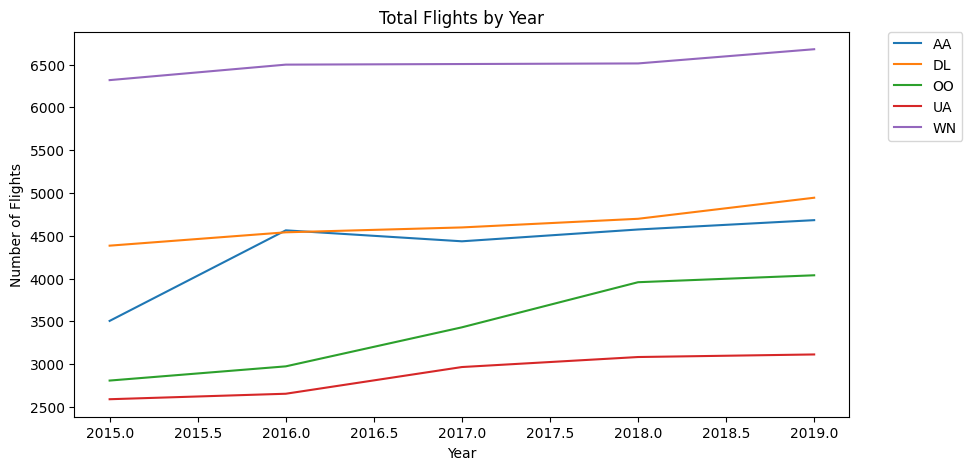

In [391]:
year_airline_total = full_data[['YEAR', 'OP_CARRIER', 'DELAYED']]
year_airline_total = year_airline_total.groupby(['OP_CARRIER','YEAR']).count()
year_airline_total.head()
year_airline_total = year_airline_total.reset_index()
year_airline_total = year_airline_total.set_index('YEAR')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_airline_total.index, y = year_airline_total['DELAYED'], hue = year_airline_total['OP_CARRIER'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(title = 'Total Flights by Year')
ax.set(xlabel = 'Year')
ax.set(ylabel = 'Number of Flights')

There are airlines with incomplete data.
* Some of these airlines merged but we don't want to attribute delays from one company to another in the past so we will remove these airlines from the data
* We will simply remove the airlines that pop up in 2018

#### Remove incomple Airlines from data

In [392]:
# NOT NECESSARY WITH REDUCED AIRLINES
# lines_2015 = list(data_2015['OP_CARRIER'].unique())
# lines_2019 = list(data_2019['OP_CARRIER'].unique())
# # Airlines in 2019 not in 2015
# line_diff1 = [x for x in lines_2019 if x not in lines_2015]
# line_diff1

In [393]:
# # Airlines in 205 not in 2019
# line_diff2 = [x for x in lines_2015 if x not in lines_2019]
# line_diff2

In [394]:
# # Combine lists
# drop_lines = line_diff1 + line_diff2
# drop_lines

In [395]:
# # Remove both sets above
# full_data = full_data[~full_data['OP_CARRIER'].isin(drop_lines)]

#### Revisit Flights by Year plot

[Text(0, 0.5, 'Number of Flights')]

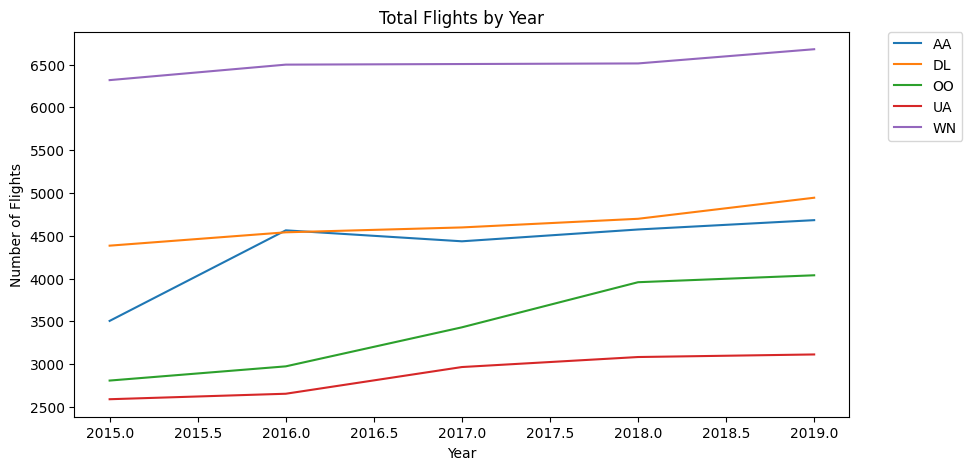

In [396]:
year_airline_total = full_data[['YEAR', 'OP_CARRIER', 'DELAYED']]
year_airline_total = year_airline_total.groupby(['OP_CARRIER','YEAR']).count()
year_airline_total.head()
year_airline_total = year_airline_total.reset_index()
year_airline_total = year_airline_total.set_index('YEAR')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_airline_total.index, y = year_airline_total['DELAYED'], hue = year_airline_total['OP_CARRIER'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(title = 'Total Flights by Year')
ax.set(xlabel = 'Year')
ax.set(ylabel = 'Number of Flights')

Comments:
* Everything looks pretty constant with the exception of EV, Atlantic Southeast

In [397]:
# Delete data frame for memory management
del[year_airline_total]
gc.collect()

715

#### Delays by Airline by Year

[Text(0, 0.5, 'Number of Delayed Flights')]

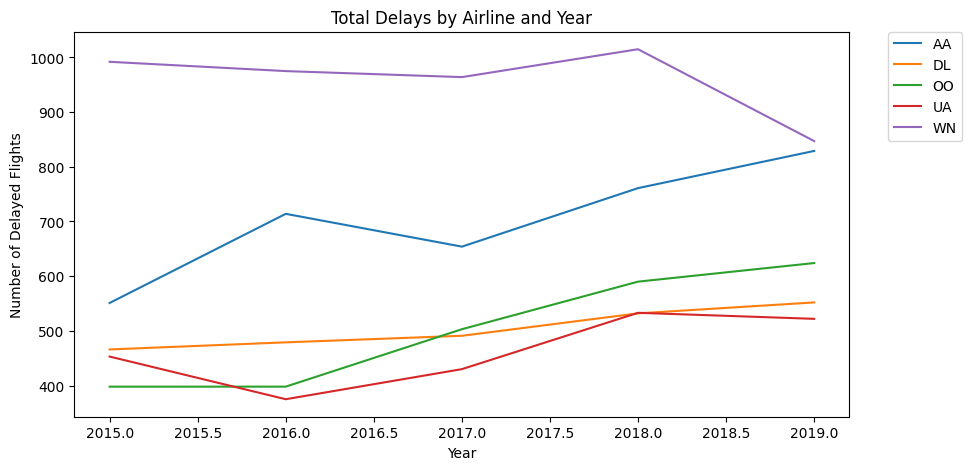

In [398]:
year_airline_total = full_data[['YEAR', 'OP_CARRIER', 'DELAYED']]
year_airline_total = year_airline_total.groupby(['OP_CARRIER','YEAR']).sum()
year_airline_total.head()
year_airline_total = year_airline_total.reset_index()
year_airline_total = year_airline_total.set_index('YEAR')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_airline_total.index, y = year_airline_total['DELAYED'], hue = year_airline_total['OP_CARRIER'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(title = 'Total Delays by Airline and Year')
ax.set(xlabel = 'Year')
ax.set(ylabel = 'Number of Delayed Flights')

Comments:
* There's a mixed bag, but it looks like overall delays across airlines increase slightly with year
* Southwest looks like it has the most delays but this is maybe due to volume
* To adjust for increased volume we can look at percentage of delays

In [399]:
# Delete data frame for memory management
del[year_airline_total]
gc.collect()

709

#### Percentage delays by Airline and Year

[Text(0, 0.5, 'Percentage of Delayed Flights')]

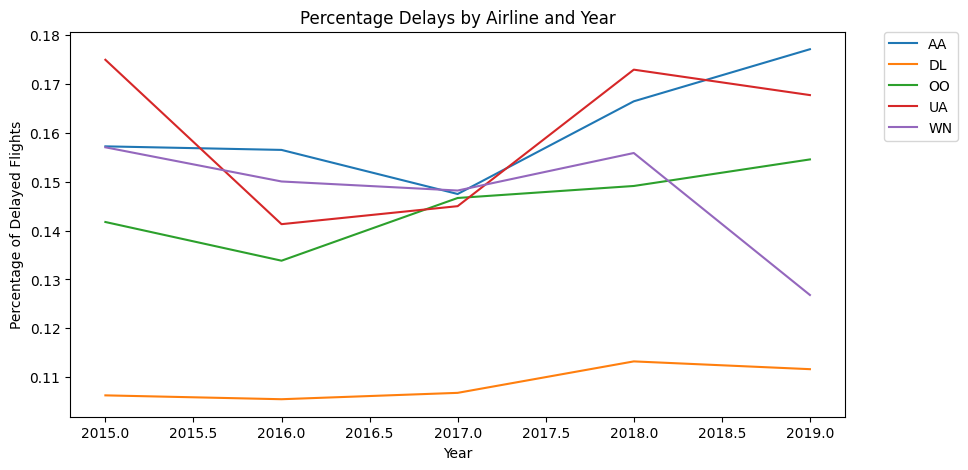

In [400]:
year_airline_pct = full_data[['YEAR', 'OP_CARRIER', 'DELAYED']]
year_airline_pct = year_airline_pct.groupby(['OP_CARRIER','YEAR']).agg(['sum', 'count'])
year_airline_pct = year_airline_pct.reset_index()
year_airline_pct['PCT_DELAYED'] = year_airline_pct['DELAYED']['sum']/year_airline_pct['DELAYED']['count']
year_airline_pct = year_airline_pct.set_index('YEAR')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_airline_pct.index, y = year_airline_pct['PCT_DELAYED'], hue = year_airline_pct['OP_CARRIER'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(title = 'Percentage Delays by Airline and Year')
ax.set(xlabel = 'Year')
ax.set(ylabel = 'Percentage of Delayed Flights')

Comments:
* Adjusting for volumn Southwest is not an outlier as we saw above
* Airline does seem to have an effect on the percentage of delayed flights though so we should add it to a model

In [401]:
# Delete data frame for memory management
del[year_airline_pct]
gc.collect()

0

#### Check number of flights by Departing Airport

In [402]:
origin_counts = full_data['ORIGIN'].value_counts()
origin_counts = pd.DataFrame(origin_counts)
origin_counts = origin_counts.reset_index()
origin_box = origin_counts.describe()

When grouped by flight origin, the 75th percentile for total number of flights over the 5 years gives an average of 1 flights a day. Since this is very low volume, we will remove any origin that falls below this cutoff.

##### Find origins below 75th percentile of total outgoing volume over the 5 years

In [403]:
origin_drops = origin_counts[origin_counts['count'] < origin_box.loc['75%'].item()]
origin_drops.T

77   78   79   80   81   82   83   84   85   86   ...  291  292  293  \
ORIGIN  COS  DSM  ICT  MSN  LIT  OGG  SBA  BZN  SBN  DAY  ...  GRK  STC  CSG   
count   192  176  168  154  144  133  132  129  125  124  ...    1    1    1   

        294  295  296  297  298  299  300  
ORIGIN  ALO  BRO  LCH  BLI  CEC  TOL  ACT  
count     1    1    1    1    1    1    1  

[2 rows x 224 columns]

#### Drop 75th Percentile of Origin volume

In [404]:
origin_drop_list = list(origin_drops['ORIGIN'])

In [405]:
# Remove origin drops
full_data = full_data[~full_data['ORIGIN'].isin(origin_drop_list)]

In [406]:
# Check effect on counts
origin_counts = full_data['ORIGIN'].value_counts()
origin_counts = pd.DataFrame(origin_counts)
origin_counts = origin_counts.reset_index()
origin_counts.describe()

count
count    77.000000
mean   1305.844156
std    1380.181730
min     211.000000
25%     374.000000
50%     856.000000
75%    1682.000000
max    7942.000000

#### Drop 75th percentile of Dest volume

In [407]:
dest_counts = full_data['DEST'].value_counts()
dest_counts = pd.DataFrame(dest_counts)
dest_counts = dest_counts.reset_index()
dest_box = dest_counts.describe()

In [408]:
# Create and remove destination drops
dest_drops = dest_counts[dest_counts['count'] < dest_box.loc['75%'].item()]
dest_drop_list = list(dest_drops['DEST'])
full_data = full_data[~full_data['DEST'].isin(dest_drop_list)]

In [409]:
# Check that it worked
dest_counts = full_data['DEST'].value_counts()
dest_counts = pd.DataFrame(dest_counts)
dest_counts = dest_counts.reset_index()
dest_counts.describe()

count
count    75.000000
mean   1225.333333
std    1142.283942
min     200.000000
25%     362.500000
50%     968.000000
75%    1681.500000
max    6014.000000

#### Percentage delays by Departing Airport

[Text(0, 0.5, 'Percentage of Delayed Flights')]

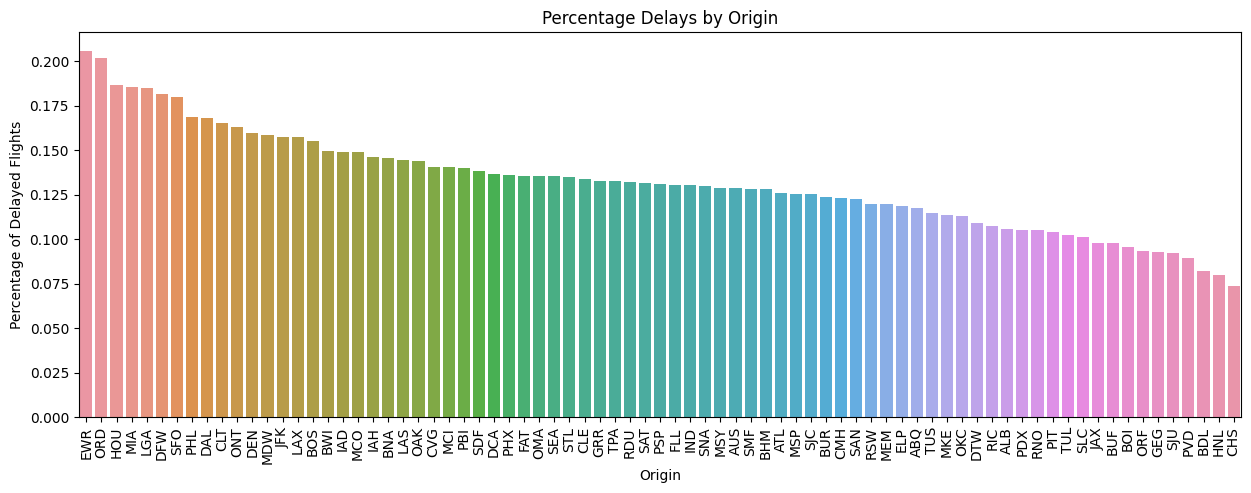

In [410]:
origin_agg_pct = full_data[['ORIGIN', 'DELAYED']]
origin_agg_pct = origin_agg_pct.groupby(['ORIGIN']).agg(['sum', 'count'])
origin_agg_pct = origin_agg_pct.reset_index()
origin_agg_pct['PCT_DELAYED'] = origin_agg_pct['DELAYED']['sum']/origin_agg_pct['DELAYED']['count']
origin_agg_pct = origin_agg_pct.sort_values('PCT_DELAYED', ascending = False)
_, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = origin_agg_pct['ORIGIN'], y = origin_agg_pct['PCT_DELAYED'])
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 90)
ax.set(title = 'Percentage Delays by Origin')
ax.set(xlabel = 'Origin')
ax.set(ylabel = 'Percentage of Delayed Flights')

Comments:
* It appears as though flight origin has an impact on percentage of flight delays so we'll add it to a model

In [411]:
# Delete data frame for memory management
del[origin_agg_pct]
gc.collect()

9

#### Percentage delays by destination

[Text(0, 0.5, 'Percentage of Delayed Flights')]

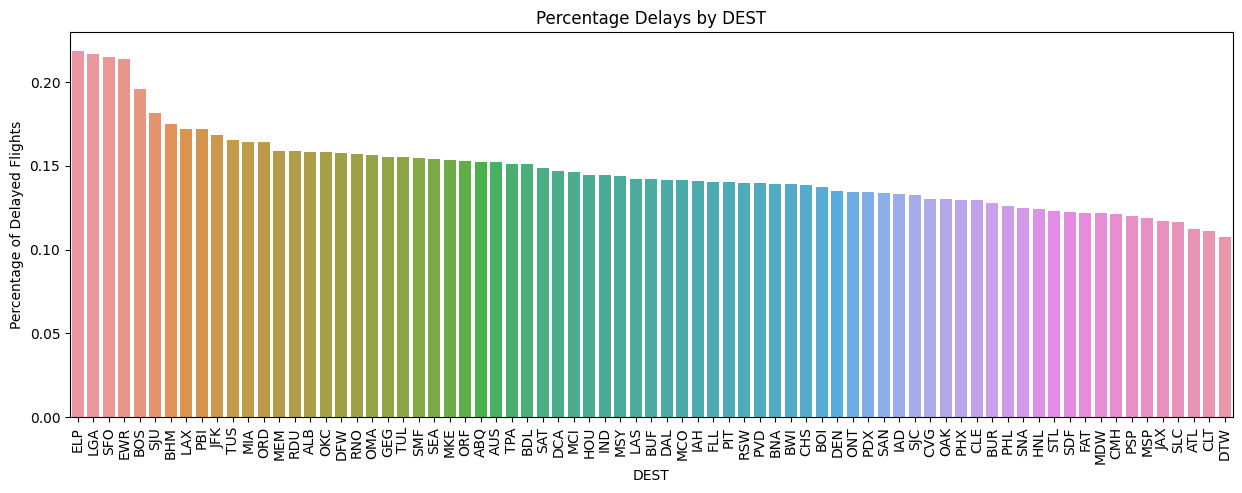

In [412]:
dest_agg_pct = full_data[['DEST', 'DELAYED']]
dest_agg_pct = dest_agg_pct.groupby(['DEST']).agg(['sum', 'count'])
dest_agg_pct = dest_agg_pct.reset_index()
dest_agg_pct['PCT_DELAYED'] = dest_agg_pct['DELAYED']['sum']/dest_agg_pct['DELAYED']['count']
dest_agg_pct = dest_agg_pct.sort_values('PCT_DELAYED', ascending = False)
_, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = dest_agg_pct['DEST'], y = dest_agg_pct['PCT_DELAYED'])
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 90)
ax.set(title = 'Percentage Delays by DEST')
ax.set(xlabel = 'DEST')
ax.set(ylabel = 'Percentage of Delayed Flights')

Comments:
* This is interesting!
    * There is a wider range of percentage delays for destination than there is origin
* Destination does appear to have an effect on percentage of delays

In [302]:
# Delete data frame for memory management
del[dest_agg_pct]
gc.collect()

6

##### Total flights by year

[Text(0, 0.5, 'Number of Flights')]

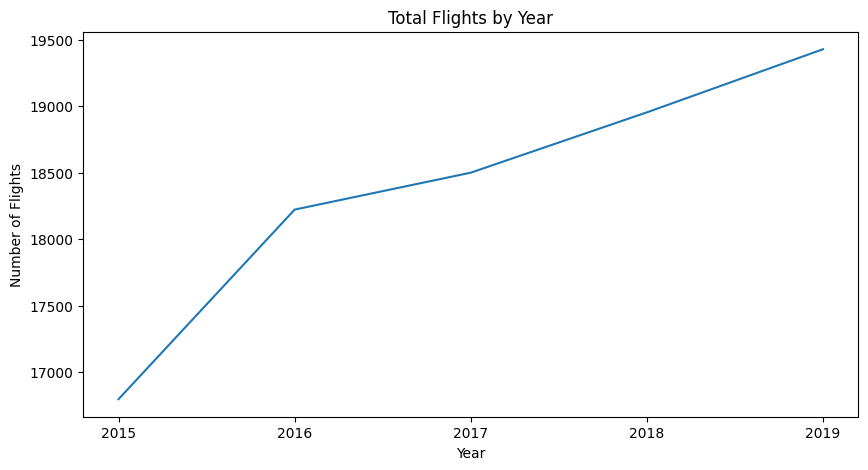

In [303]:
year_total = full_data[['YEAR', 'DELAYED']]
year_total = year_total.groupby('YEAR').count()
year_total.head()
year_total = year_total.reset_index()
year_total['YEAR'] = year_total['YEAR'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_total['YEAR'], y = year_total['DELAYED'])
ax.set(title = 'Total Flights by Year')
ax.set(xlabel = 'Year')
ax.set(ylabel = 'Number of Flights')

Comments:
* It looks like total flights by year has increased over time

In [304]:
# Delete data frame for memory management
del[year_total]
gc.collect()

144

##### Delayed flights by year

[Text(0, 0.5, 'Delayed')]

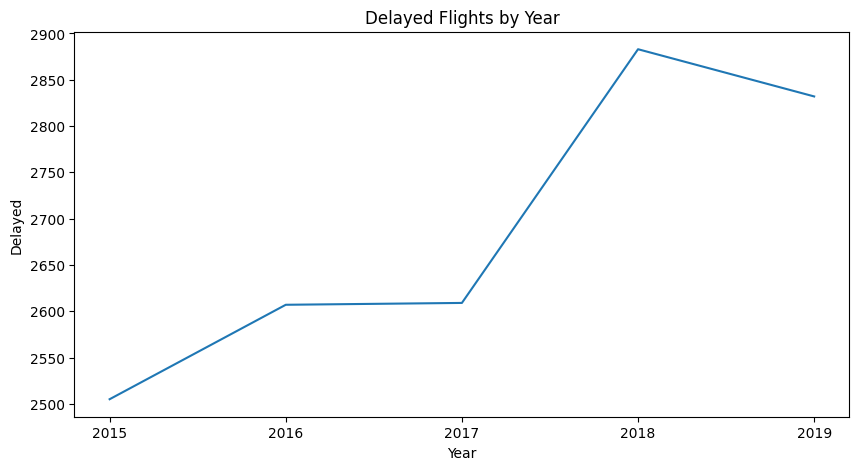

In [305]:
year_grouped = full_data[['YEAR', 'DELAYED']]
year_grouped = year_grouped.groupby('YEAR').sum()
year_grouped.head()
year_grouped = year_grouped.reset_index()
year_grouped['YEAR'] = year_grouped['YEAR'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_grouped['YEAR'], y = year_grouped['DELAYED'])
ax.set(title = 'Delayed Flights by Year')
ax.set(xlabel = 'Year')
ax.set(ylabel = 'Delayed')

Comments:
* Overall it looks like delays have increased over time

In [306]:
# Delete data frame for memory management
del[year_grouped]
gc.collect()

174

##### Percentage delayed flights by year

[Text(0, 0.5, 'Percentage Delayed')]

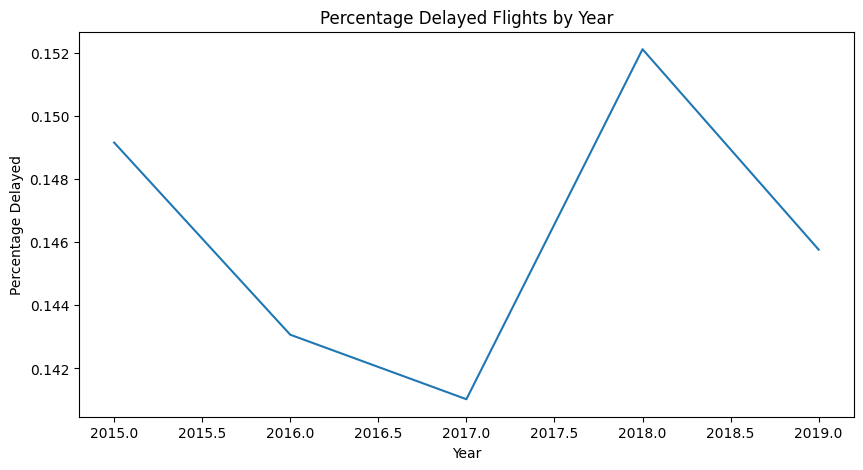

In [307]:
year_pct_agg = full_data[['YEAR','DELAYED']]
year_pct_agg = year_pct_agg.groupby(['YEAR']).agg(['sum', 'count'])
year_pct_agg = year_pct_agg.reset_index()
year_pct_agg['PCT_DELAYED'] = year_pct_agg['DELAYED']['sum']/year_pct_agg['DELAYED']['count']
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_pct_agg['YEAR'], y = year_pct_agg['PCT_DELAYED'])
ax.set(title = 'Percentage Delayed Flights by Year')
ax.set(xlabel = 'Year')
ax.set(ylabel = 'Percentage Delayed')

Comments:
* It does not looke like overall percentage of delayed flights has increased significantly over time

In [308]:
# Delete data frame for memory management
del[year_pct_agg]
gc.collect()

180

##### Delayed flights by month yearly comparison

[Text(0, 0.5, 'Delayed')]

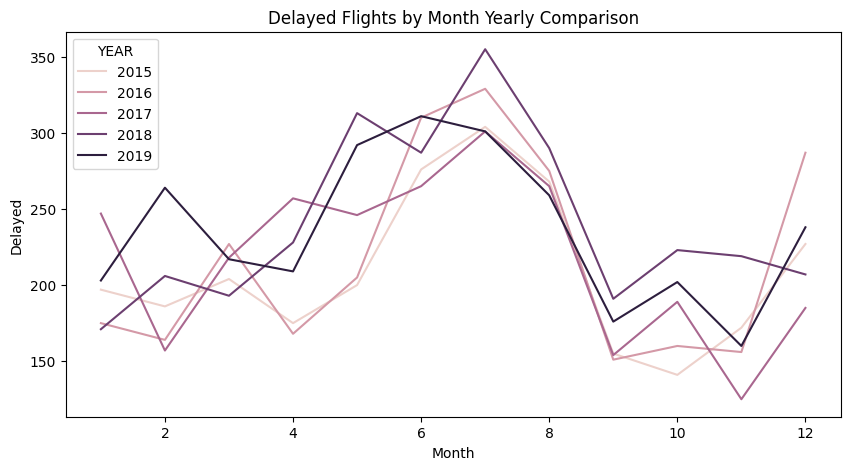

In [309]:
year_month = full_data[['YEAR', 'MONTH', 'DELAYED']]
year_month = year_month.groupby(['YEAR', 'MONTH']).sum()
year_month = year_month.reset_index()
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_month['MONTH'], y = year_month['DELAYED'], hue = year_month['YEAR'])
ax.set(title = 'Delayed Flights by Month Yearly Comparison')
ax.set(xlabel = 'Month')
ax.set(ylabel = 'Delayed')

Comments:
* Again, it appears as though delays have not increased significantly over time
* There appears to be some monthly trend, with increased delays in the summer and in December
    * Interestingly, there doesn't appear to be an increase in delays in November, which we might expect for Thanksgiving
        * This might be due to the number of flights in early November offsetting the number later in the month

This brings up looking at percentage of delayed flights by total number of flights over year and month

In [310]:
# Delete data frame for memory management
del[year_month]
gc.collect()

184

[Text(0, 0.5, 'Percentage Delayed')]

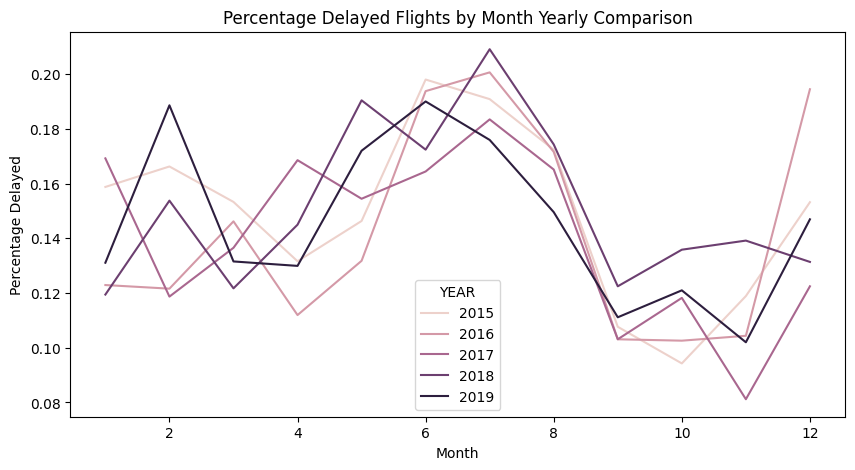

In [311]:
year_month_agg = full_data[['YEAR', 'MONTH', 'DELAYED']]
year_month_agg = year_month_agg.groupby(['YEAR', 'MONTH']).agg(['sum', 'count'])
year_month_agg = year_month_agg.reset_index()
year_month_agg['PCT_DELAYED'] = year_month_agg['DELAYED']['sum']/year_month_agg['DELAYED']['count']
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = year_month_agg['MONTH'], y = year_month_agg['PCT_DELAYED'], hue = year_month_agg['YEAR'])
ax.set(title = 'Percentage Delayed Flights by Month Yearly Comparison')
ax.set(xlabel = 'Month')
ax.set(ylabel = 'Percentage Delayed')

Comments:
* The percentage of delayed flights per month doesn't appear to change over year, whereas the count is (this is expected since overall flights has increased over time)

In [312]:
# Delete data frame for memory management
del[year_month_agg]
gc.collect()

162

##### Delayed flights by month and day

[Text(0, 0.5, 'Delayed')]

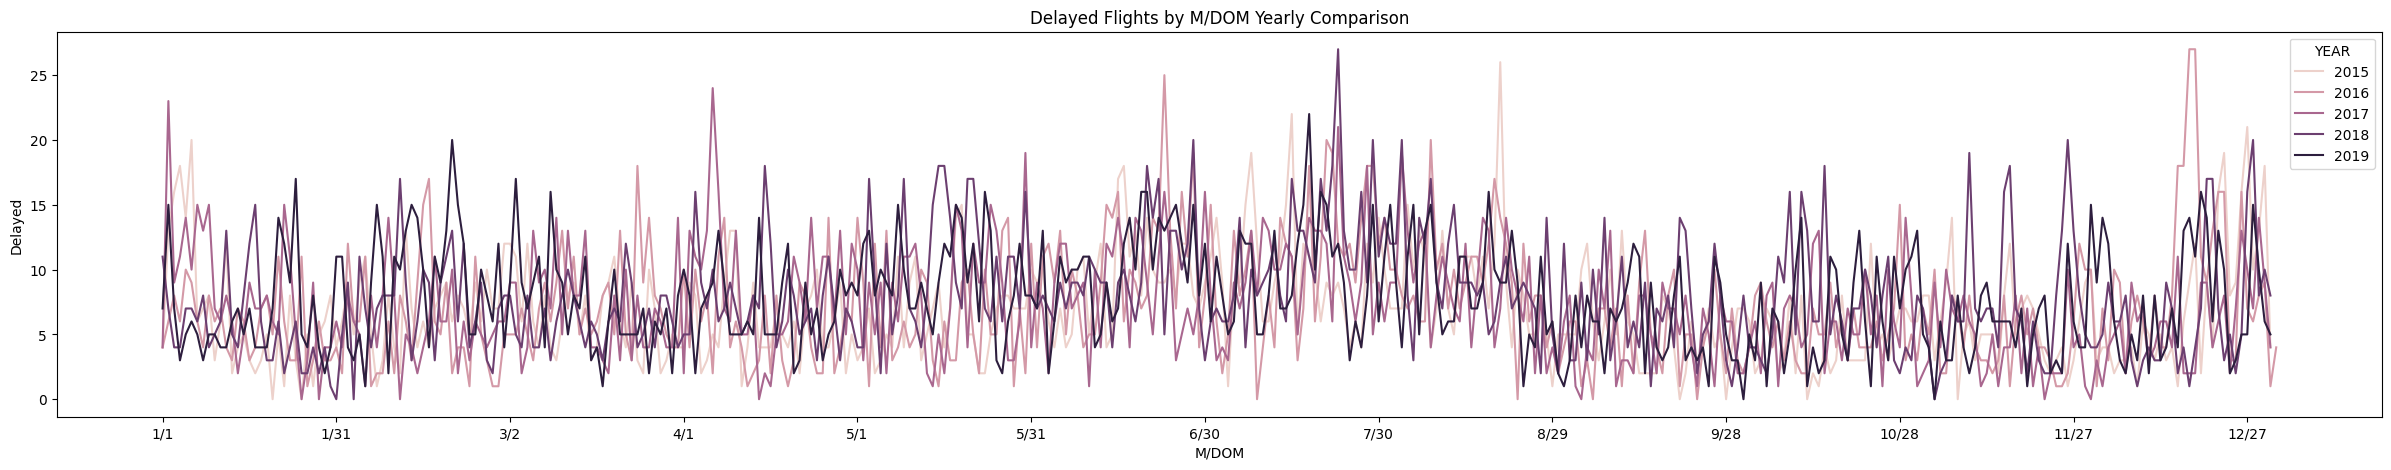

In [313]:
year_day_agg = full_data[['YEAR', 'MONTH', 'DOM', 'DELAYED']]
year_day_agg = year_day_agg.groupby(['YEAR', 'MONTH', 'DOM']).sum()
year_day_agg = year_day_agg.reset_index()
year_day_agg['M/DOM'] = year_day_agg['MONTH'].astype('str') + '/' + year_day_agg['DOM'].astype('str')
_, ax = plt.subplots(figsize = (30, 5))
sns.lineplot(x = year_day_agg['M/DOM'], y = year_day_agg['DELAYED'], hue = year_day_agg['YEAR'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.set(title = 'Delayed Flights by M/DOM Yearly Comparison')
ax.set(xlabel = 'M/DOM')
ax.set(ylabel = 'Delayed')

Comments:
* This looks prety noisy so it is hard to have any take-aways

In [314]:
# Delete data frame for memory management
del[year_day_agg]
gc.collect()

250

#### Delayed flights by Day of Week

[Text(0, 0.5, 'Delayed')]

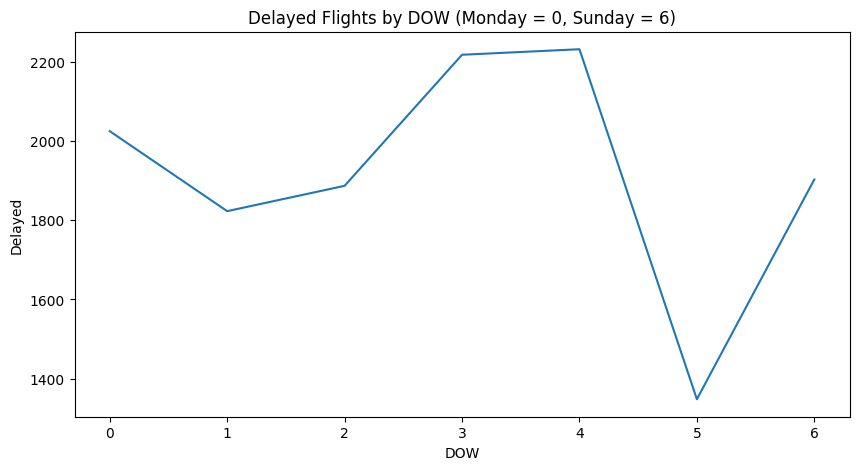

In [315]:
dow_grouped = full_data[['DOW', 'DELAYED']]
dow_grouped = dow_grouped.groupby('DOW').sum()
dow_grouped.head()
dow_grouped = dow_grouped.reset_index()
dow_grouped['DOW'] = dow_grouped['DOW'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = dow_grouped['DOW'], y = dow_grouped['DELAYED'])
ax.set(title = 'Delayed Flights by DOW (Monday = 0, Sunday = 6)')
ax.set(xlabel = 'DOW')
ax.set(ylabel = 'Delayed')

Comments:
* It looks like there may be an impact of DOW on flight delays, with fewer delays on the Tuesday, Wednesday, Saturdays, and Sundays
* To check this we'll look at this by percentage of total

In [316]:
# Delete data frame for memory management
del[dow_grouped]
gc.collect()

147

[Text(0, 0.5, 'Percentage Delayed')]

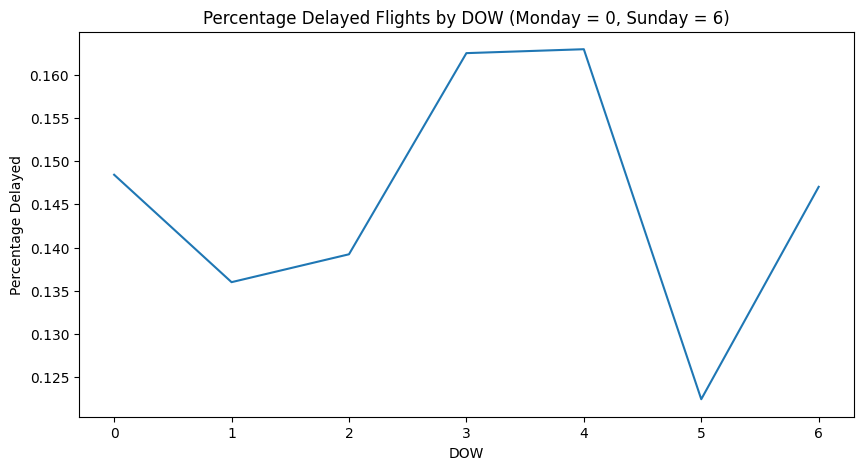

In [317]:
dow_pct_agg = full_data[['DOW', 'DELAYED']]
dow_pct_agg = dow_pct_agg.groupby(['DOW']).agg(['sum', 'count'])
dow_pct_agg = dow_pct_agg.reset_index()
dow_pct_agg['PCT_DELAYED'] = dow_pct_agg['DELAYED']['sum']/dow_pct_agg['DELAYED']['count']
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = dow_pct_agg['DOW'], y = dow_pct_agg['PCT_DELAYED'])
ax.set(title = 'Percentage Delayed Flights by DOW (Monday = 0, Sunday = 6)')
ax.set(xlabel = 'DOW')
ax.set(ylabel = 'Percentage Delayed')

Comments:
* It appears as though this is actually a trend — we'll add a DOW seasonality to the model

In [318]:
# Delete data frame for memory management
del[dow_pct_agg]
gc.collect()

180

Just for fun let's look at number of flights by DOW

[Text(0, 0.5, 'Number of Flights')]

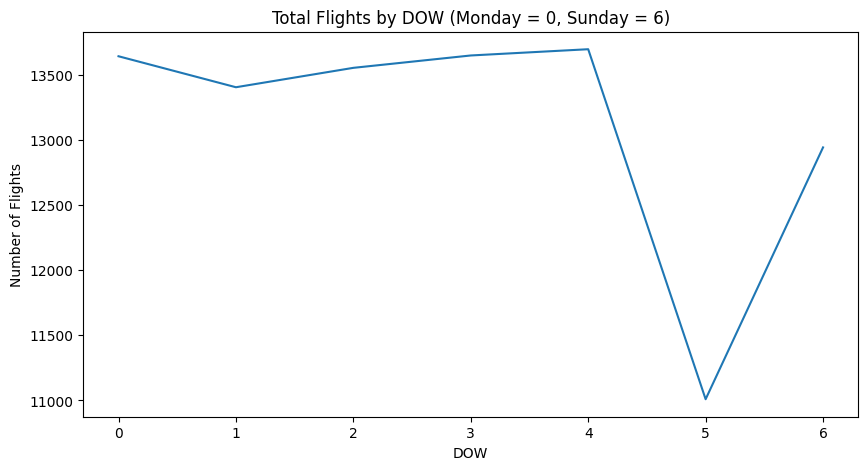

In [319]:
dow_total = full_data[['DOW', 'DELAYED']]
dow_total = dow_total.groupby('DOW').count()
dow_total.head()
dow_total = dow_total.reset_index()
dow_total['DOW'] = dow_total['DOW'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = dow_total['DOW'], y = dow_total['DELAYED'])
ax.set(title = 'Total Flights by DOW (Monday = 0, Sunday = 6)')
ax.set(xlabel = 'DOW')
ax.set(ylabel = 'Number of Flights')

Comments:
* There are fewer flights on Saturdays and Sundays, generally

In [320]:
# Delete data frame for memory management
del[dow_total]
gc.collect()

162

##### Delayed flights by Hour and Hour PCT

[Text(0, 0.5, 'Number of Delays')]

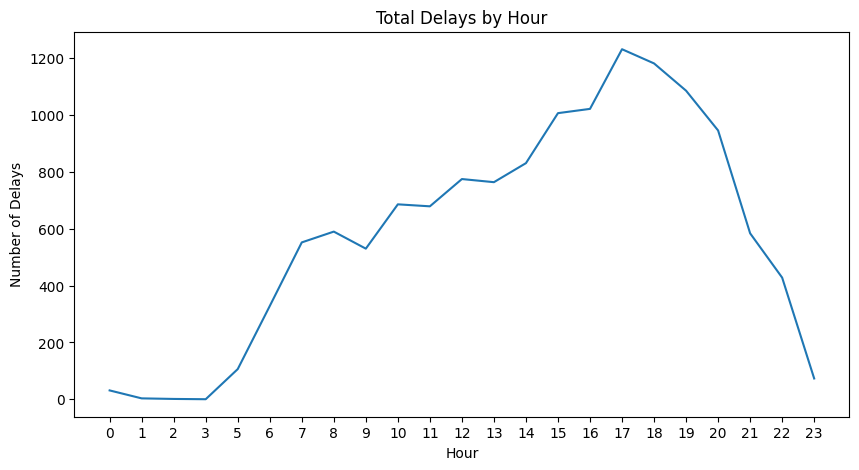

In [321]:
hour_total = full_data[['HOUR', 'DELAYED']]
hour_total = hour_total.groupby('HOUR').sum()
hour_total.head()
hour_total = hour_total.reset_index()
hour_total['HOUR'] = hour_total['HOUR'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = hour_total['HOUR'], y = hour_total['DELAYED'])
ax.set(title = 'Total Delays by Hour')
ax.set(xlabel = 'Hour')
ax.set(ylabel = 'Number of Delays')

Comments:
* Number of delayed flights increases with hour of the day
    * This makes sense as flights throughout the day are affected by the timeliness of previous flights. Thus flights earlier in the day have less of a chance of being delayed as there are fewer previous flights.
* To double check we can compare this with the percentage of delayed flights by hour

In [322]:
# Delete data frame for memory management
del[hour_total]
gc.collect()

157

[Text(0, 0.5, 'Percentage of Delays')]

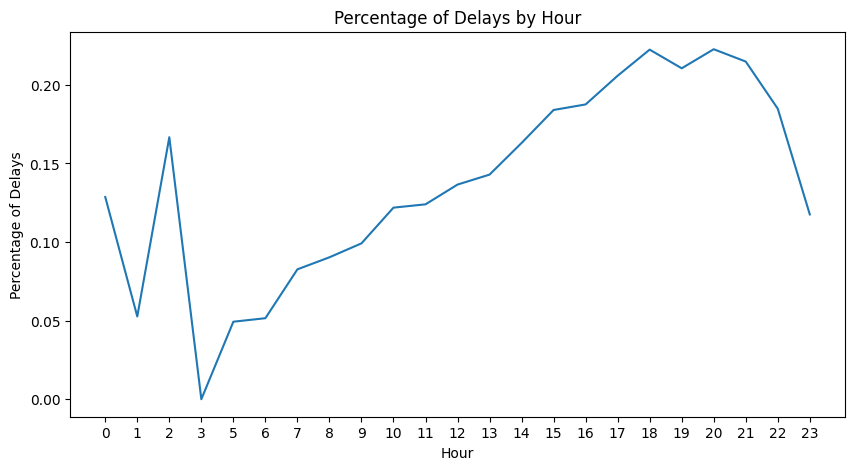

In [323]:
hour_pct_agg = full_data[['HOUR', 'DELAYED']]
hour_pct_agg = hour_pct_agg.groupby('HOUR').agg(['sum', 'count'])
hour_pct_agg = hour_pct_agg.reset_index()
hour_pct_agg['PCT_DELAYED'] = hour_pct_agg['DELAYED']['sum']/hour_pct_agg['DELAYED']['count']
hour_pct_agg['HOUR'] = hour_pct_agg['HOUR'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = hour_pct_agg['HOUR'], y = hour_pct_agg['PCT_DELAYED'])
ax.set(title = 'Percentage of Delays by Hour')
ax.set(xlabel = 'Hour')
ax.set(ylabel = 'Percentage of Delays')

Comments:
* This corroborates the previous idea, with the added realization that it seels likely that the early flights here are dependent on the previous day's flights, with an apparent reset around 5:00AM

In [324]:
# Delete data frame for memory management
del[hour_pct_agg]
gc.collect()

160

##### Delayed flights by Minute and Minute PCT

[Text(0, 0.5, 'Number of Delays')]

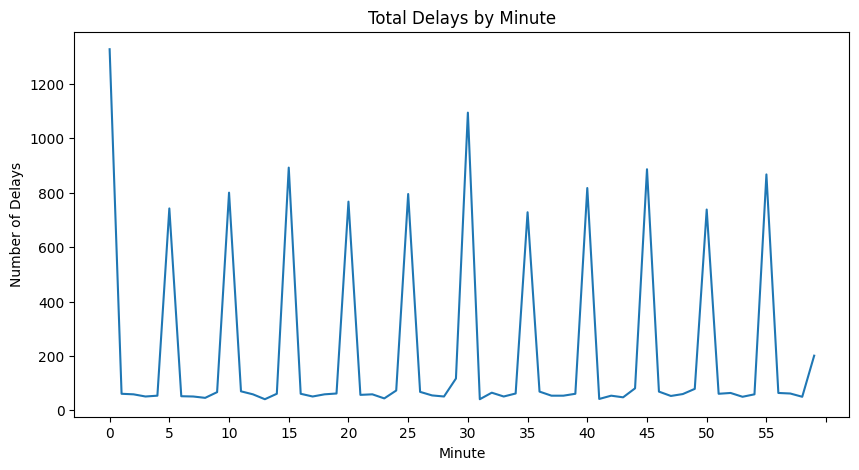

In [325]:
minute_total = full_data[['MINUTE', 'DELAYED']]
minute_total = minute_total.groupby('MINUTE').sum()
minute_total.head()
minute_total = minute_total.reset_index()
minute_total['MINUTE'] = minute_total['MINUTE'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = minute_total['MINUTE'], y = minute_total['DELAYED'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set(title = 'Total Delays by Minute')
ax.set(xlabel = 'Minute')
ax.set(ylabel = 'Number of Delays')

Comments:
* This looks like a trend, but it's more indicative of when flights are scheduled to leave being based around 5 minute intervals
* Just to make sure, we'll look at percentages

In [326]:
# Delete data frame for memory management
del[minute_total]
gc.collect()

175

[Text(0, 0.5, 'Percentage of Delays')]

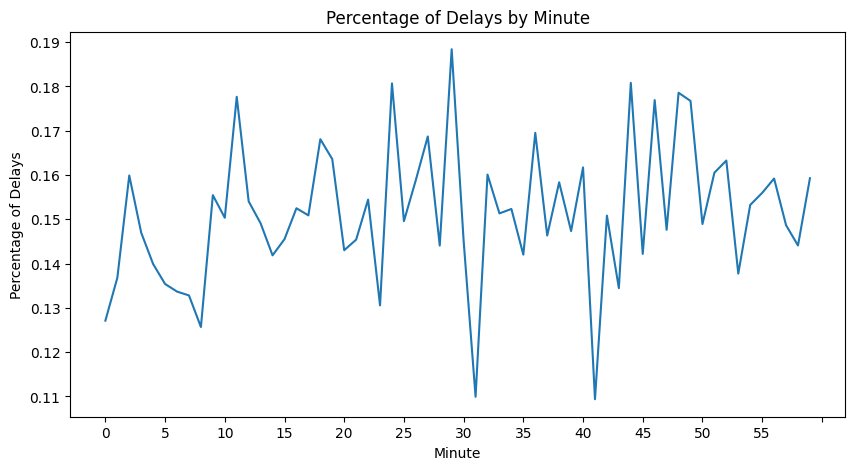

In [327]:
minute_pct_agg = full_data[['MINUTE', 'DELAYED']]
minute_pct_agg = minute_pct_agg.groupby('MINUTE').agg(['sum', 'count'])
minute_pct_agg = minute_pct_agg.reset_index()
minute_pct_agg['PCT_DELAYED'] = minute_pct_agg['DELAYED']['sum']/minute_pct_agg['DELAYED']['count']
minute_pct_agg['MINUTE'] = minute_pct_agg['MINUTE'].astype('str')
_, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = minute_pct_agg['MINUTE'], y = minute_pct_agg['PCT_DELAYED'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set(title = 'Percentage of Delays by Minute')
ax.set(xlabel = 'Minute')
ax.set(ylabel = 'Percentage of Delays')

Comments:
* Indeed it appears as though minute does not have a significant impact on percentage of delays

In [328]:
# Delete data frame for memory management
del[minute_pct_agg]
gc.collect()

169

#### Percentage delayed flights by minute and hour

[Text(0, 0.5, 'Percentage Delayed')]

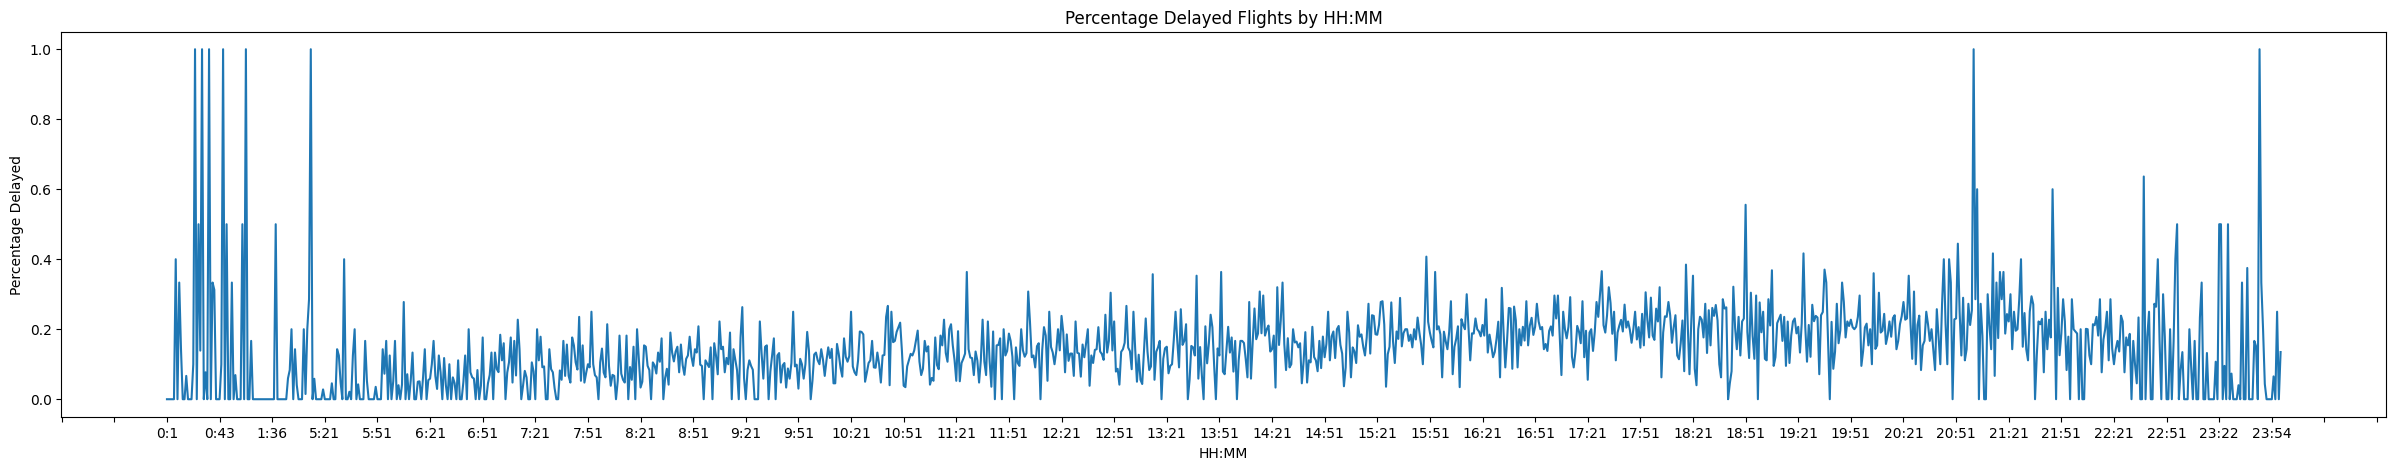

In [115]:
minute_hour_pct = full_data[['HOUR', 'MINUTE', 'DELAYED']]
minute_hour_pct = minute_hour_pct.groupby(['HOUR', 'MINUTE']).agg(['sum', 'count'])
minute_hour_pct = minute_hour_pct.reset_index()
minute_hour_pct['HH:MM'] = minute_hour_pct['HOUR'].astype('str') + ':' + minute_hour_pct['MINUTE'].astype('str')
minute_hour_pct['PCT_DELAYED'] = minute_hour_pct['DELAYED']['sum']/minute_hour_pct['DELAYED']['count']
_, ax = plt.subplots(figsize = (30, 5))
sns.lineplot(x = minute_hour_pct['HH:MM'], y = minute_hour_pct['PCT_DELAYED'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.set(title = 'Percentage Delayed Flights by HH:MM')
ax.set(xlabel = 'HH:MM')
ax.set(ylabel = 'Percentage Delayed')

Comments:
* Late day/early day percentages have a lot of noise, but for the bulk of flight times there appears to be a slight increasing trend
* This does not indicate a strong minute trend — it appears as though hour can capture this trend reasonably enough, so we won't include minute data

In [116]:
# Delete data frame for memory management
del[minute_hour_pct]
gc.collect()

370

### Drop unnecessary data frames to free up memory

In [117]:
# del[[
#     reduced_data,
#      data_2015,
#      data_2016,
#      data_2017,
#      data_2018,
#      data_2019,
#      minute_hour_pct,
#      minute_pct_agg,
#      minute_total,
#      hour_pct_agg,
#      hour_total,
#      dow_grouped,
#      dow_pct_agg, 
#      year_day_agg,
#      year_airline_total,
#      year_airline_pct,
#      year_month,
#      year_total,
#      year_month_agg,
#      year_grouped,
#      dest_agg_pct,
#      origin_agg_pct]]

### Modeling

#### Basic model for predicting number of delayed flights in a given period

* For an intial model we will use:
    * Hour
    * DOW
    * DOY
    * Month
    * Destination
    * Origin
    * Carrier


* To have something to evaluate performance on, we'll reseve December 2019 as test data and use all previous data to train the model.


#### ZeroSumNormal code for time series priors

In [118]:
# helper functions to support the analysis

def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax, label=''):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3, label=label)

#### Make reduced dataset for use in modeling

##### Select the columns we want

In [119]:
full_data = full_data[['index', 'DATETIME', 'HOUR', 'DOW', 'DOY', 'MONTH', 'DEST', 'ORIGIN', 'OP_CARRIER', 'DELAYED']]

In [120]:
# Create simple lists for dimensions to pass to pymc model
hour_strings = full_data.HOUR.unique().astype('str')
weekday_strings = full_data.DOW.unique().astype('str')
dayofyear_strings = full_data.DOY.unique().astype('str')
month_strings = full_data.MONTH.unique().astype('str')
origin_strings = full_data.ORIGIN.unique().astype('str')
dest_strings = full_data.DEST.unique().astype('str')
carrier_strings = full_data['OP_CARRIER'].unique().astype('str')

#### One-hot encode DEST, ORIGIN, and CARRIER

In [121]:
origin_dummies = pd.get_dummies(full_data[['ORIGIN']], dtype = int, sparse = True)

In [122]:
full_data = full_data.drop(['ORIGIN'], axis = 1)
full_data = full_data.join(origin_dummies)
del[origin_dummies]
gc.collect()

0

In [123]:
dest_dummies = pd.get_dummies(full_data[['DEST']], dtype = int, sparse = True)

In [124]:
full_data = full_data.drop(['DEST'], axis = 1)
full_data = full_data.join(dest_dummies)
del[dest_dummies]
gc.collect()

0

In [125]:
carrier_dummies = pd.get_dummies(full_data[['OP_CARRIER']], dtype = int, sparse = False)

In [126]:
full_data = full_data.drop(['OP_CARRIER'], axis = 1)
full_data = full_data.join(carrier_dummies)
del[carrier_dummies]
gc.collect()

0

#### Create train/test split

In [127]:
full_data = full_data.set_index('DATETIME')
train = full_data[full_data.index < '2019-12-01']
test = full_data[full_data.index >= '2019-12-01']

In [128]:
# Drop full data for memory management
del[full_data]
gc.collect()

0

In [129]:
train.shape

(90280, 163)

In [130]:
train.head()

index  HOUR  DOW  DOY  MONTH  DELAYED  ORIGIN_ABQ  ORIGIN_ALB  \
DATETIME                                                                    
2015-01-01    605     9    3    1      1        0           0           0   
2015-01-01  12474    12    3    1      1        0           0           0   
2015-01-01  12990     7    3    1      1        0           0           0   
2015-01-01  12304    20    3    1      1        1           0           0   
2015-01-01  13802    13    3    1      1        0           0           0   

            ORIGIN_ATL  ORIGIN_AUS  ...  DEST_SNA  DEST_STL  DEST_TPA  \
DATETIME                            ...                                 
2015-01-01           0           0  ...         0         0         0   
2015-01-01           0           0  ...         0         0         0   
2015-01-01           0           0  ...         0         0         0   
2015-01-01           0           0  ...         0         0         0   
2015-01-01           0           0  ...         0         0         0   

            DEST_TUL  DEST_TUS  OP_CARRIER_AA  OP_CARRIER_DL  OP_CARRIER_OO  \
DATETIME                                                                      
2015-01-01         0         0              0              0              1   
2015-01-01         0         0              0              1              0   
2015-01-01         0         0              0              1              0   
2015-01-01         0         0              0              1              0   
2015-01-01         0         0              0              1              0   

            OP_CARRIER_UA  OP_CARRIER_WN  
DATETIME                                  
2015-01-01              0              0  
2015-01-01              0              0  
2015-01-01              0              0  
2015-01-01              0              0  
2015-01-01              0              0  

[5 rows x 163 columns]

##### Find column indices for ORIGIN, DEST, and OP_CARRIER one-hots

In [131]:
origin_start = min([i for i, s in enumerate(list(train.columns)) if 'ORIGIN' in s])
origin_end = max([i for i, s in enumerate(list(train.columns)) if 'ORIGIN' in s]) + 1
dest_start = min([i for i, s in enumerate(list(train.columns)) if 'DEST' in s])
dest_end = max([i for i, s in enumerate(list(train.columns)) if 'DEST' in s]) + 1
carrier_start = min([i for i, s in enumerate(list(train.columns)) if 'OP_CARRIER' in s])
carrier_end = max([i for i, s in enumerate(list(train.columns)) if 'OP_CARRIER' in s]) + 1

#### Full Logistic model

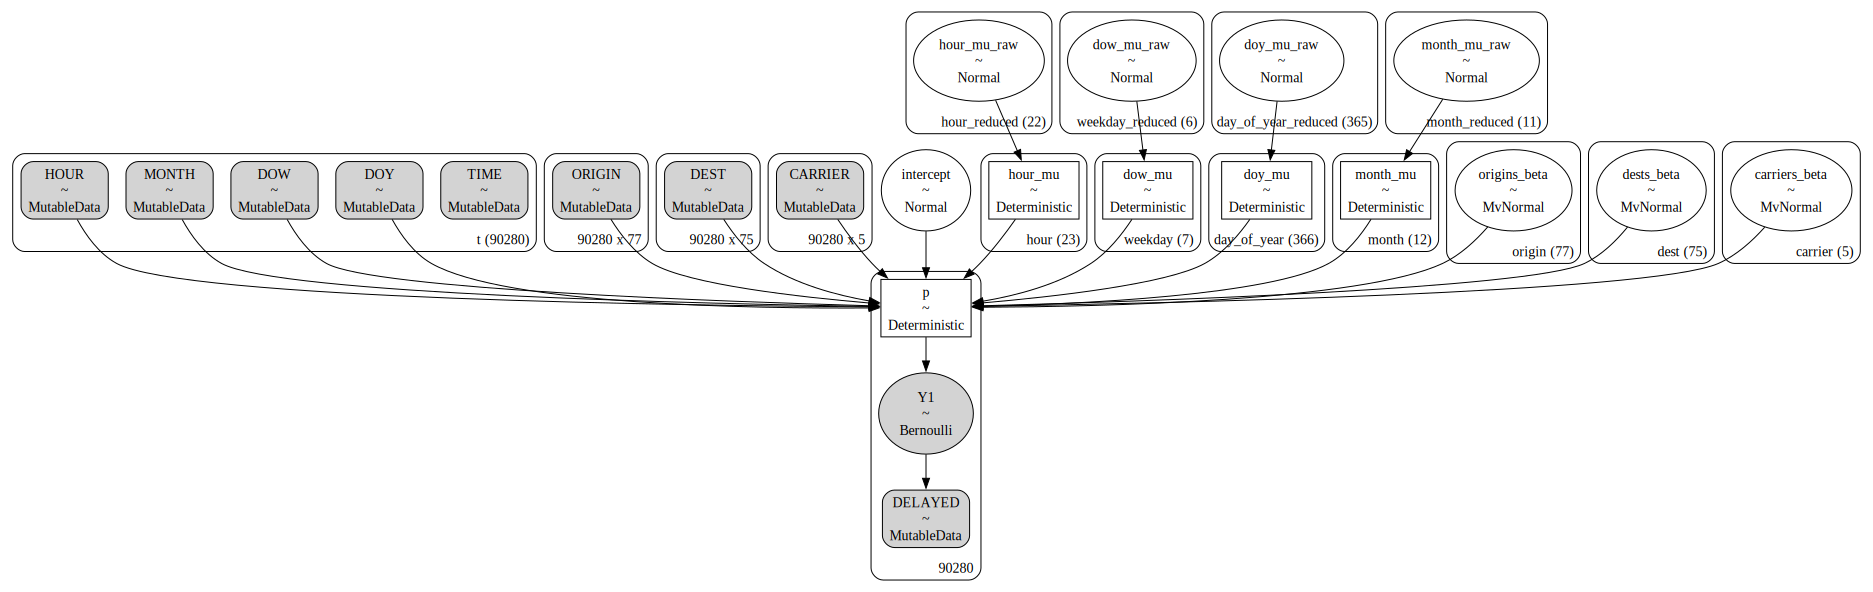

In [132]:
# Full logistic regression model
with pm.Model(coords={'hour': hour_strings,
                      'weekday': weekday_strings,
                      'day_of_year': dayofyear_strings,
                      'month': month_strings,
                      'origin': origin_strings,
                      'dest': dest_strings,
                      'carrier': carrier_strings}) as log_model:
    # observed predictors and outcome
    Y = pm.MutableData('DELAYED', train.iloc[:, 5])
    hour = pm.MutableData('HOUR', train['HOUR'].to_numpy(), dims = 't')
    dow = pm.MutableData('DOW', train['DOW'].to_numpy(), dims = 't')
    doy = pm.MutableData('DOY', train['DOY'].to_numpy(), dims = 't')
    month = pm.MutableData('MONTH', train['MONTH'].to_numpy(), dims = 't')
    time = pm.MutableData('TIME', train['index'].to_numpy(), dims = 't')
    origins = pm.MutableData('ORIGIN', train.iloc[:, origin_start:origin_end])
    dests = pm.MutableData('DEST', train.iloc[:, dest_start:dest_end])
    carriers = pm.MutableData('CARRIER', train.iloc[:, carrier_start:carrier_end])


    # priors
    intercept = pm.Normal('intercept', 0, 10)
    hour_mu = ZeroSumNormal('hour_mu', sigma = 1, dims = 'hour')
    dow_mu = ZeroSumNormal('dow_mu', sigma = 1, dims = 'weekday')
    doy_mu = ZeroSumNormal('doy_mu', sigma = 1, dims = 'day_of_year')
    month_mu = ZeroSumNormal('month_mu', sigma = 1, dims = 'month')
    #linear_trend = pm.TruncatedNormal('linear trend', 0, 10, lower=0)
    origins_beta = pm.MvNormal('origins_beta',
                               mu = np.zeros(origin_end-origin_start),
                               cov = np.eye(origin_end-origin_start),
                               #nu = (origin_end-origin_start-1),
                               shape = origin_end-origin_start,
                               dims = 'origin')
    dests_beta = pm.MvNormal('dests_beta',
                               mu = np.zeros(dest_end-dest_start),
                               cov = np.eye(dest_end-dest_start),
                               #nu = (dest_end-dest_start-1),
                               shape = dest_end-dest_start,
                               dims = 'dest')
    carriers_beta = pm.MvNormal('carriers_beta',
                               mu = np.zeros(carrier_end-carrier_start),
                               cov = np.eye(carrier_end-carrier_start),
                               #nu = 4, # 1-#of carriers
                               shape = carrier_end-carrier_start,
                               dims = 'carrier')

    # Model specification
    mu = (
        intercept +
        (hour_mu[hour - 1]) +
        (dow_mu[dow - 1]) +
        (doy_mu[doy - 1]) +
        (month_mu[month - 1]) +
        #(linear_trend * time) +
        (pm.math.dot(origins , origins_beta)) +
        (pm.math.dot(dests , dests_beta)) +
        (pm.math.dot(carriers , carriers_beta))
    )

    p = pm.Deterministic("p", pm.invlogit(mu))
    Y1 = pm.Bernoulli("Y1", p = p, observed = Y)

# Model graphic
g = pm.model_to_graphviz(log_model)
g

In [133]:
with log_model:
    advi_fit = pm.fit(15000, method='advi', random_seed = 6040)

Finished [100%]: Average Loss = 36,291


##### ELBO Plot

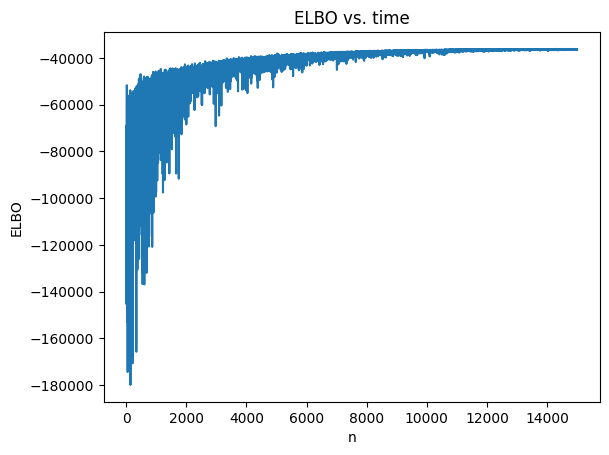

In [134]:
# plot the ELBO vs. fitting time or iterations (n)
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
#ax.set(xlim=(300000,500000), ylim = (-10000, 0))
ax.set_title("ELBO vs. time")
plt.show()

Comments:
* It looks like this converged! The ELBO smoothed out but the axis scale is very large.

##### Full model trace

In [135]:
# sample from the variational posterior distribution
advi_samples = 5000
log_advi_trace = advi_fit.sample(advi_samples, return_inferencedata = False)
log_advi_trace = pm.to_inference_data(trace = log_advi_trace, model = log_model, log_likelihood = True)

#### Model without carrier

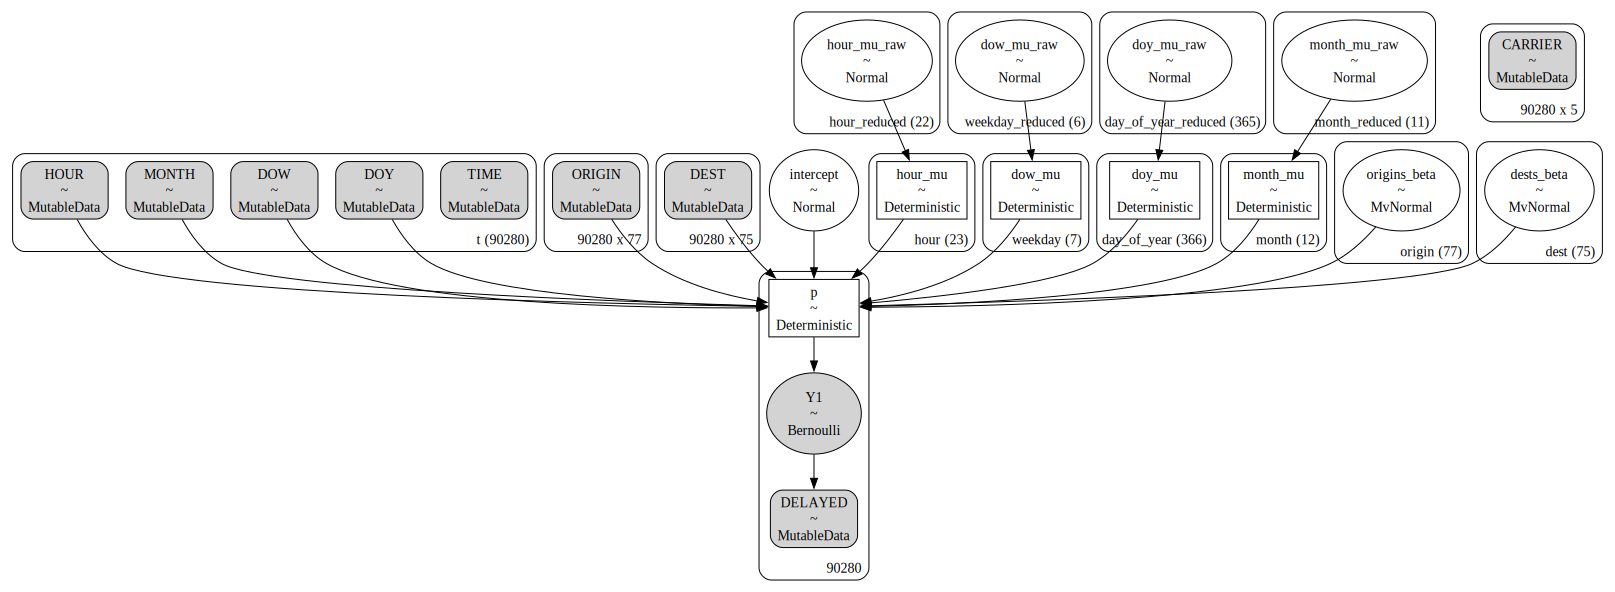

In [136]:
#No carrier logistic regression model
with pm.Model(coords={'hour': hour_strings,
                      'weekday': weekday_strings,
                      'day_of_year': dayofyear_strings,
                      'month': month_strings,
                      'origin': origin_strings,
                      'dest': dest_strings,
                      'carrier': carrier_strings}) as nc_log_model:
    # observed predictors and outcome
    Y = pm.MutableData('DELAYED', train.iloc[:, 5])
    hour = pm.MutableData('HOUR', train['HOUR'].to_numpy(), dims = 't')
    dow = pm.MutableData('DOW', train['DOW'].to_numpy(), dims = 't')
    doy = pm.MutableData('DOY', train['DOY'].to_numpy(), dims = 't')
    month = pm.MutableData('MONTH', train['MONTH'].to_numpy(), dims = 't')
    time = pm.MutableData('TIME', train['index'].to_numpy(), dims = 't')
    origins = pm.MutableData('ORIGIN', train.iloc[:, origin_start:origin_end])
    dests = pm.MutableData('DEST', train.iloc[:, dest_start:dest_end])
    carriers = pm.MutableData('CARRIER', train.iloc[:, carrier_start:carrier_end])


    # priors
    intercept = pm.Normal('intercept', 0, 10)
    hour_mu = ZeroSumNormal('hour_mu', sigma = 1, dims = 'hour')
    dow_mu = ZeroSumNormal('dow_mu', sigma = 1, dims = 'weekday')
    doy_mu = ZeroSumNormal('doy_mu', sigma = 1, dims = 'day_of_year')
    month_mu = ZeroSumNormal('month_mu', sigma = 1, dims = 'month')
    #linear_trend = pm.TruncatedNormal('linear trend', 0, 10, lower=0)
    origins_beta = pm.MvNormal('origins_beta',
                               mu = np.zeros(origin_end-origin_start),
                               cov = np.eye(origin_end-origin_start),
                               #nu = (origin_end-origin_start-1),
                               shape = origin_end-origin_start,
                               dims = 'origin')
    dests_beta = pm.MvNormal('dests_beta',
                               mu = np.zeros(dest_end-dest_start),
                               cov = np.eye(dest_end-dest_start),
                               #nu = (dest_end-dest_start-1),
                               shape = dest_end-dest_start,
                               dims = 'dest')
    # carriers_beta = pm.MvNormal('carriers_beta',
    #                            mu = np.zeros(carrier_end-carrier_start),
    #                            cov = np.eye(carrier_end-carrier_start),
    #                            #nu = 4, # 1-#of carriers
    #                            shape = carrier_end-carrier_start,
    #                            dims = 'carrier')

    # Model specification
    mu = (
        intercept +
        (hour_mu[hour - 1]) +
        (dow_mu[dow - 1]) +
        (doy_mu[doy - 1]) +
        (month_mu[month - 1]) +
        #(linear_trend * time) +
        (pm.math.dot(origins , origins_beta)) +
        (pm.math.dot(dests , dests_beta))
        #(pm.math.dot(carriers , carriers_beta))
    )

    p = pm.Deterministic("p", pm.invlogit(mu))
    Y1 = pm.Bernoulli("Y1", p = p, observed = Y)

# Model graphic
g1 = pm.model_to_graphviz(nc_log_model)
g1

In [137]:
with nc_log_model:
    nc_advi_fit = pm.fit(15000, method='advi', random_seed = 6040)

Finished [100%]: Average Loss = 36,288


##### No carrier ELBO plot

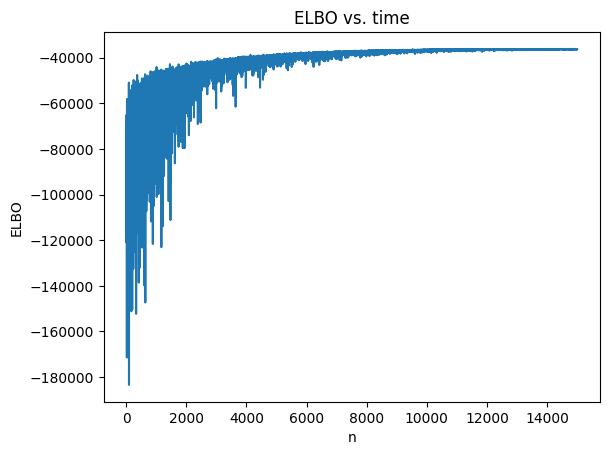

In [138]:
# plot the ELBO vs. fitting time or iterations (n)
nc_advi_elbo = pd.DataFrame(
    {'ELBO': -nc_advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=nc_advi_elbo)
#ax.set(xlim=(300000,500000), ylim = (-10000, 0))
ax.set_title("ELBO vs. time")
plt.show()

##### No carrier trace

In [139]:
# sample from the variational posterior distribution
nc_log_advi_trace = nc_advi_fit.sample(advi_samples, return_inferencedata = False)
nc_log_advi_trace = pm.to_inference_data(trace = nc_log_advi_trace, model = nc_log_model, log_likelihood = True)

#### Carrier only model

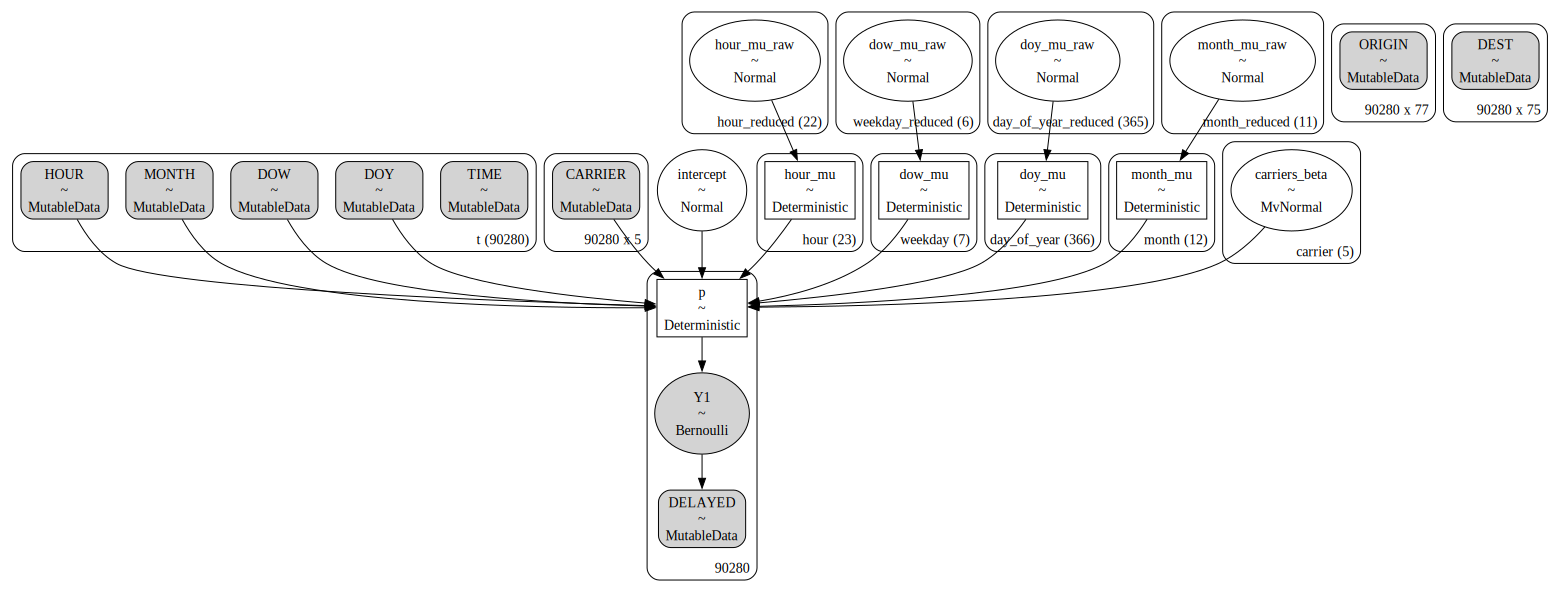

In [140]:
#Carrier only model
with pm.Model(coords={'hour': hour_strings,
                      'weekday': weekday_strings,
                      'day_of_year': dayofyear_strings,
                      'month': month_strings,
                      'origin': origin_strings,
                      'dest': dest_strings,
                      'carrier': carrier_strings}) as carrier_log_model:
    # observed predictors and outcome
    Y = pm.MutableData('DELAYED', train.iloc[:, 5])
    hour = pm.MutableData('HOUR', train['HOUR'].to_numpy(), dims = 't')
    dow = pm.MutableData('DOW', train['DOW'].to_numpy(), dims = 't')
    doy = pm.MutableData('DOY', train['DOY'].to_numpy(), dims = 't')
    month = pm.MutableData('MONTH', train['MONTH'].to_numpy(), dims = 't')
    time = pm.MutableData('TIME', train['index'].to_numpy(), dims = 't')
    origins = pm.MutableData('ORIGIN', train.iloc[:, origin_start:origin_end])
    dests = pm.MutableData('DEST', train.iloc[:, dest_start:dest_end])
    carriers = pm.MutableData('CARRIER', train.iloc[:, carrier_start:carrier_end])


    # priors
    intercept = pm.Normal('intercept', 0, 10)
    hour_mu = ZeroSumNormal('hour_mu', sigma = 1, dims = 'hour')
    dow_mu = ZeroSumNormal('dow_mu', sigma = 1, dims = 'weekday')
    doy_mu = ZeroSumNormal('doy_mu', sigma = 1, dims = 'day_of_year')
    month_mu = ZeroSumNormal('month_mu', sigma = 1, dims = 'month')
    #linear_trend = pm.TruncatedNormal('linear trend', 0, 10, lower=0)
    # origins_beta = pm.MvNormal('origins_beta',
    #                            mu = np.zeros(origin_end-origin_start),
    #                            cov = np.eye(origin_end-origin_start),
    #                            #nu = (origin_end-origin_start-1),
    #                            shape = origin_end-origin_start,
    #                            dims = 'origin')
    # dests_beta = pm.MvNormal('dests_beta',
    #                            mu = np.zeros(dest_end-dest_start),
    #                            cov = np.eye(dest_end-dest_start),
    #                            #nu = (dest_end-dest_start-1),
    #                            shape = dest_end-dest_start,
    #                            dims = 'dest')
    carriers_beta = pm.MvNormal('carriers_beta',
                               mu = np.zeros(carrier_end-carrier_start),
                               cov = np.eye(carrier_end-carrier_start),
                               #nu = 4, # 1-#of carriers
                               shape = carrier_end-carrier_start,
                               dims = 'carrier')

    # Model specification
    mu = (
        intercept +
        (hour_mu[hour - 1]) +
        (dow_mu[dow - 1]) +
        (doy_mu[doy - 1]) +
        (month_mu[month - 1]) +
        # #(linear_trend * time) +
        # (pm.math.dot(origins , origins_beta)) +
        # (pm.math.dot(dests , dests_beta))
        (pm.math.dot(carriers , carriers_beta))
    )

    p = pm.Deterministic("p", pm.invlogit(mu))
    Y1 = pm.Bernoulli("Y1", p = p, observed = Y)

# Model graphic
g2 = pm.model_to_graphviz(carrier_log_model)
g2

In [141]:
with carrier_log_model:
    carrier_advi_fit = pm.fit(15000, method='advi', random_seed = 6040)

Finished [100%]: Average Loss = 36,312


##### Carrier ELBO plot

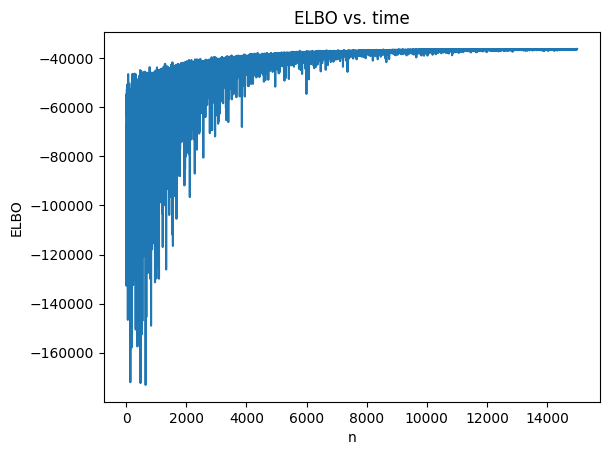

In [142]:
# plot the ELBO vs. fitting time or iterations (n)
carrier_advi_elbo = pd.DataFrame(
    {'ELBO': -carrier_advi_fit.hist,
     'n': np.arange(carrier_advi_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=carrier_advi_elbo)
#ax.set(xlim=(300000,500000), ylim = (-10000, 0))
ax.set_title("ELBO vs. time")
plt.show()

##### Carrier only trace

In [143]:
# sample from the variational posterior distribution
carrier_log_advi_trace = carrier_advi_fit.sample(advi_samples, return_inferencedata = False)
carrier_log_advi_trace = pm.to_inference_data(trace = carrier_log_advi_trace, model = carrier_log_model, log_likelihood = True)

#### WAIC model comparison

In [144]:
cmp_df = az.compare({'model_full':log_advi_trace,
                     'model_nc':nc_log_advi_trace,
                     'model_carrier':carrier_log_advi_trace},
                     ic='waic')
cmp_df

rank     elpd_waic       p_waic   elpd_diff        weight  \
model_nc          0 -35977.135237   911.154389    0.000000  6.878129e-01   
model_full        1 -36040.693341  1038.879642   63.558104  5.303181e-11   
model_carrier     2 -36139.536554   719.585757  162.401317  3.121871e-01   

                       se        dse  warning scale  
model_nc       189.006710   0.000000    False   log  
model_full     191.207589  11.616895    False   log  
model_carrier  188.069406  29.484780    False   log

Comments:
* The model with only carrier and no origin and destination info performs best
* The model with origin and destination info and no carrier information is still useful
* The full model performs worst
* The comparison of the no-carrier and carrier models makes sense given the sheer number of predictors in the no-carrier model
    * We're still interested in the information in these two models so we will evaluate both of them separately

### Analysis of Destination and Origin Model

#### Prior Predictive performance

In [145]:
nc_log_prior_pred = pm.sample_prior_predictive(samples = 100, model = nc_log_model, random_seed = 6040) 

Sampling: [Y1, dests_beta, dow_mu_raw, doy_mu_raw, hour_mu_raw, intercept, month_mu_raw, origins_beta]


Text(0.5, 1.0, 'Prior Predictive Distribtution for Origin/Dest Model')

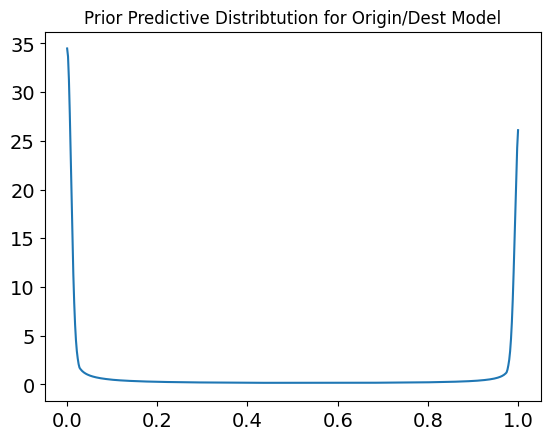

In [415]:
ax = az.plot_dist(nc_log_prior_pred.prior['p'])
ax.set_title('Prior Predictive Distribtution for Origin/Dest Model')

#### Posterior predictive performance

In [147]:
nc_log_post_pred = pm.sample_posterior_predictive(nc_log_advi_trace, model = nc_log_model, random_seed = 6040, return_inferencedata = True)

Sampling: [Y1]


Text(0.5, 1.0, 'Posterior Predictive Check for Origin/Dest Model')

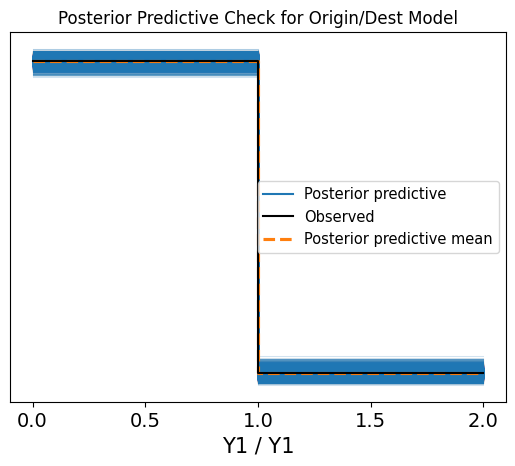

In [420]:
ax = az.plot_ppc(nc_log_post_pred)
ax.set_title('Posterior Predictive Check for Origin/Dest Model')

##### Bayesian P-Value

Text(0.5, 1.0, 'Bayesian P-Value Plot for Origin/Dest Model')

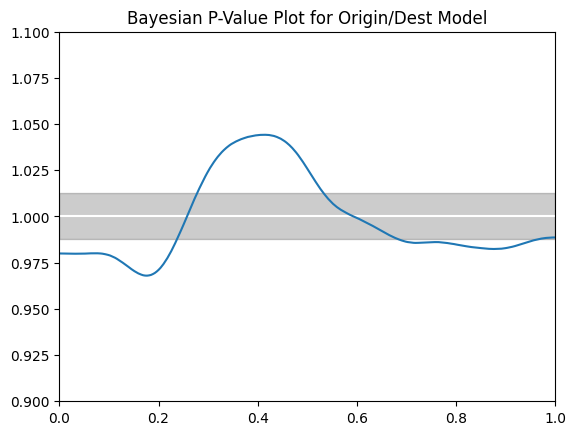

In [421]:
ax = az.plot_bpv(nc_log_post_pred)
ax.set_ylim([0.9, 1.1])
ax.set_title('Bayesian P-Value Plot for Origin/Dest Model')

#### Coefficients analysis

##### Origin Betas

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

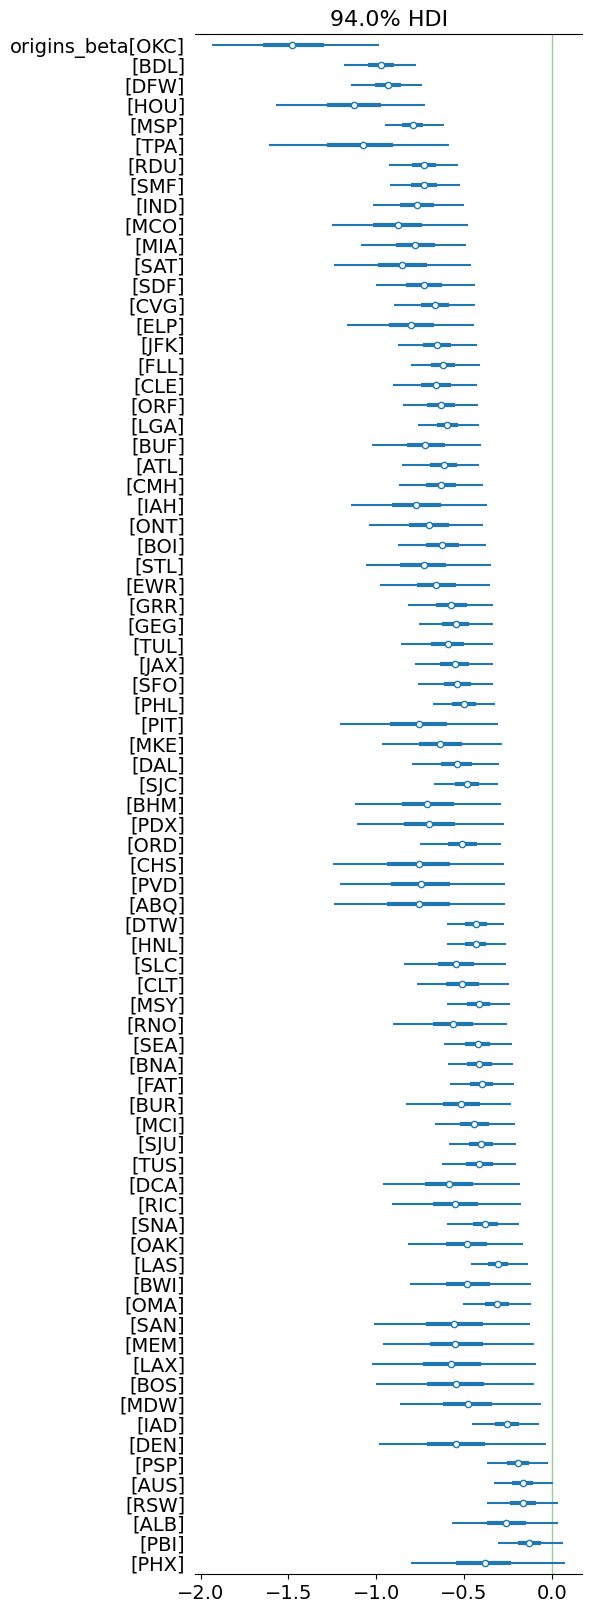

In [150]:
# Code to order origin betas by 97% hdi
quan_origin = nc_log_advi_trace.posterior['origins_beta'].quantile((.97), dim=("chain", "draw"))
sorted_origin = nc_log_advi_trace.posterior['origin'].sortby(quan_origin)
pm.summary(nc_log_advi_trace, var_names = ['origins_beta'], coords={"origin":sorted_origin})
pm.plot_forest(nc_log_advi_trace, var_names = ['origins_beta'], figsize = (5, 20), rope = (0,0), coords={"origin":sorted_origin})

In [151]:
# List of significant origin betas
origin_sigs = pm.summary(nc_log_advi_trace, var_names = ['origins_beta'], coords = {'origin':sorted_origin})
origin_sig_list = list(origin_sigs[(origin_sigs['hdi_3%'] < 0) & (origin_sigs['hdi_97%'] < 0)].index)
origin_sig_list = [x[-4:-1] for x in origin_sig_list]

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

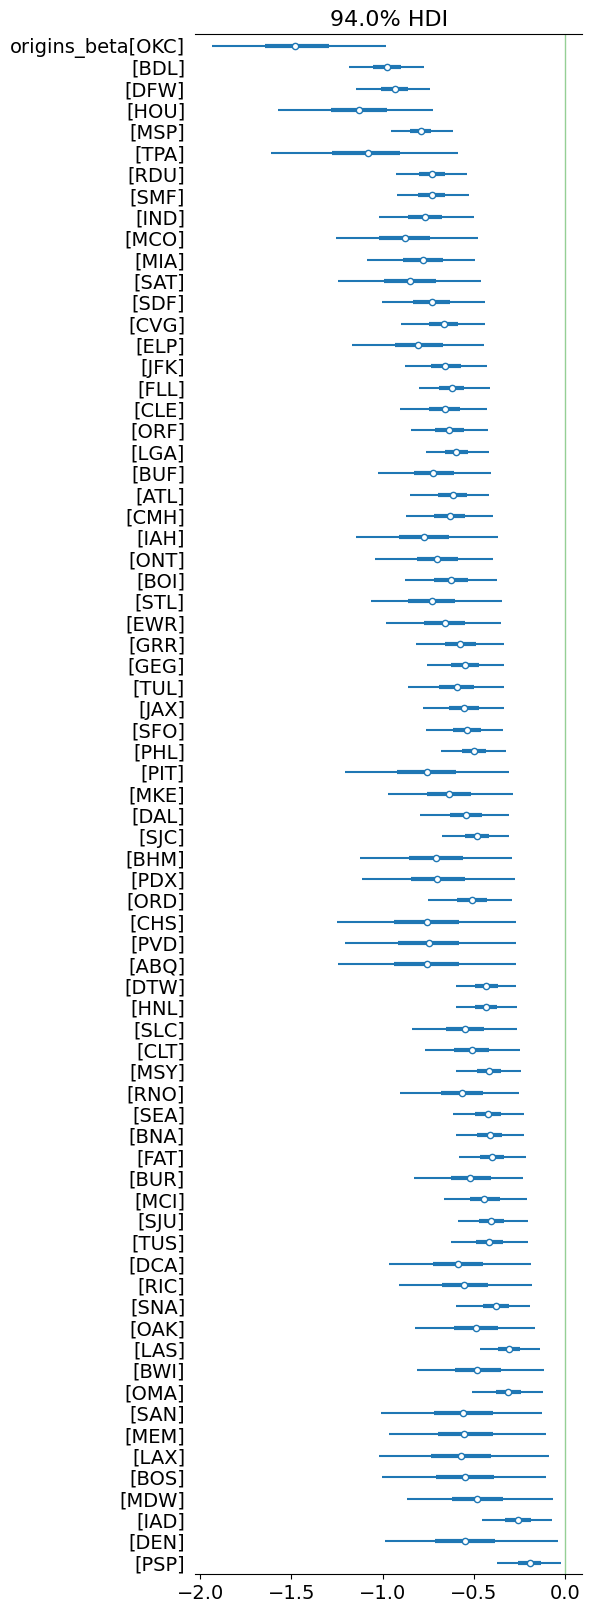

In [152]:
# Only significant origin betas
pm.plot_forest(nc_log_advi_trace, var_names = ['origins_beta'], figsize = (5, 20), rope = (0,0), coords={"origin":origin_sig_list})

In [153]:
# Only significant origin betas
#pm.plot_posterior(log_advi_trace, var_names = ['origins_beta'], coords={"origin":origin_sig_list}, ref_val = 0)

##### Dest betas

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

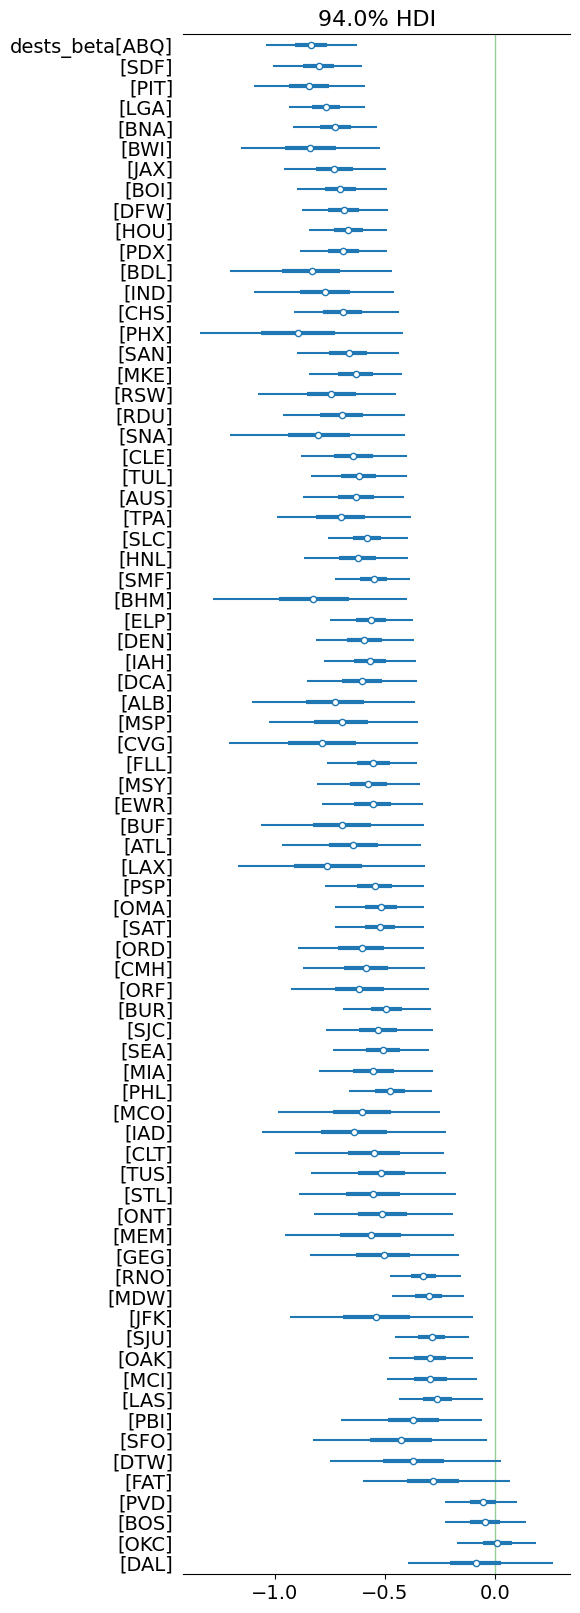

In [154]:
# Code to order dest betas by 97% hdi
quan_dest = nc_log_advi_trace.posterior['dests_beta'].quantile((.97), dim=("chain", "draw"))
sorted_dest = nc_log_advi_trace.posterior['dest'].sortby(quan_dest)
pm.plot_forest(nc_log_advi_trace, var_names = ['dests_beta'], figsize = (5, 20), rope = (0,0), coords={"dest":sorted_dest})

In [155]:
# List of significant dest betas
dest_sigs = pm.summary(nc_log_advi_trace, var_names = ['dests_beta'], coords = {'dest':sorted_dest})
dest_sig_list = list(dest_sigs[(dest_sigs['hdi_3%'] < 0) & (dest_sigs['hdi_97%'] < 0)].index)
dest_sig_list = [x[-4:-1] for x in dest_sig_list]

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

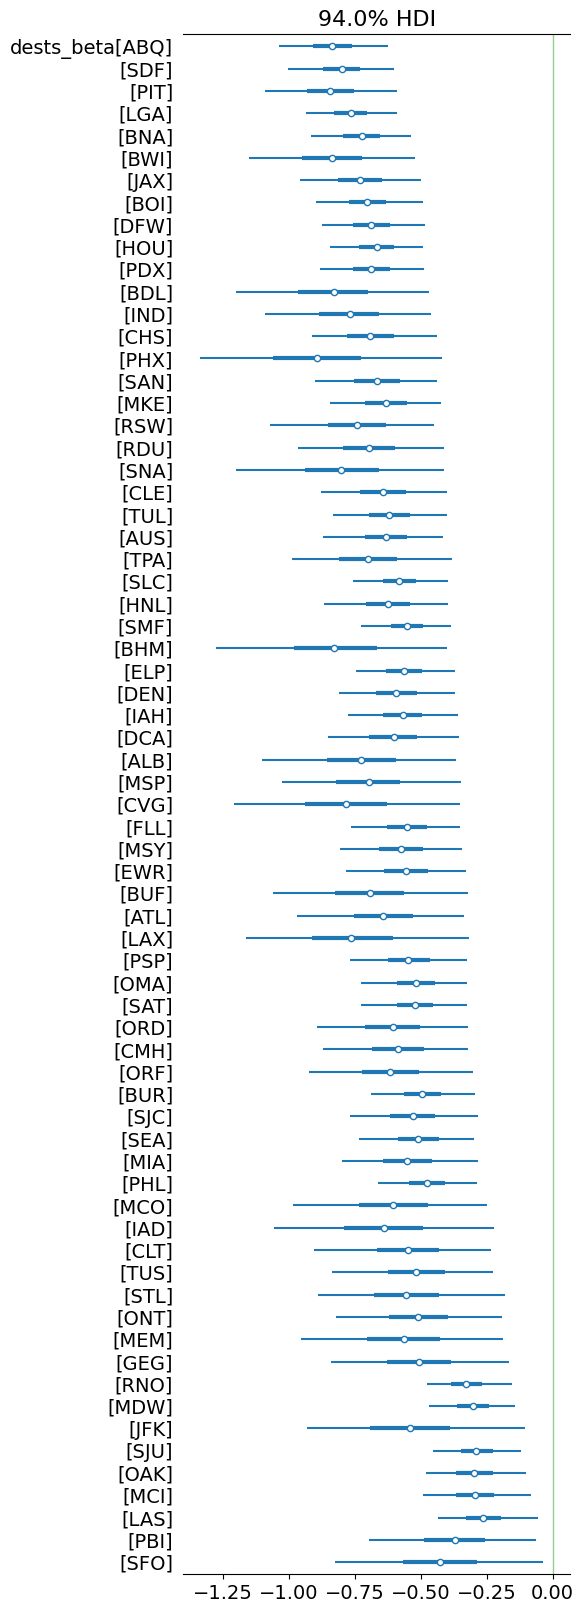

In [156]:
# Only significant dest betas
pm.plot_forest(nc_log_advi_trace, var_names = ['dests_beta'], figsize = (5, 20), rope = (0,0), coords={"dest":dest_sig_list})

In [157]:
# Only significant dest betas
# pm.plot_posterior(log_advi_trace, var_names = ['dests_beta'], coords={"dest":dest_sig_list}, ref_val = 0)

##### Origin and Destination significant airports

In [158]:
# Find overlaps in significant departure and origin betas
sig_ports = list(set(dest_sig_list) & set(origin_sig_list))
sig_ports

['BOI',
 'PIT',
 'LAX',
 'SMF',
 'BHM',
 'BDL',
 'EWR',
 'IND',
 'TUS',
 'PSP',
 'TUL',
 'JAX',
 'JFK',
 'DFW',
 'GEG',
 'SDF',
 'PDX',
 'STL',
 'LGA',
 'PHL',
 'MCI',
 'SFO',
 'CMH',
 'SAN',
 'BNA',
 'HNL',
 'SJU',
 'MDW',
 'OAK',
 'DEN',
 'ABQ',
 'IAH',
 'MCO',
 'MSP',
 'SNA',
 'ELP',
 'SJC',
 'CHS',
 'OMA',
 'BUR',
 'FLL',
 'DCA',
 'SEA',
 'ONT',
 'MEM',
 'SLC',
 'BUF',
 'HOU',
 'ATL',
 'CVG',
 'BWI',
 'RDU',
 'MSY',
 'SAT',
 'MKE',
 'IAD',
 'CLE',
 'CLT',
 'RNO',
 'MIA',
 'ORF',
 'LAS',
 'TPA',
 'ORD']

#### Time Coefficients

##### Hour Coefficients

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

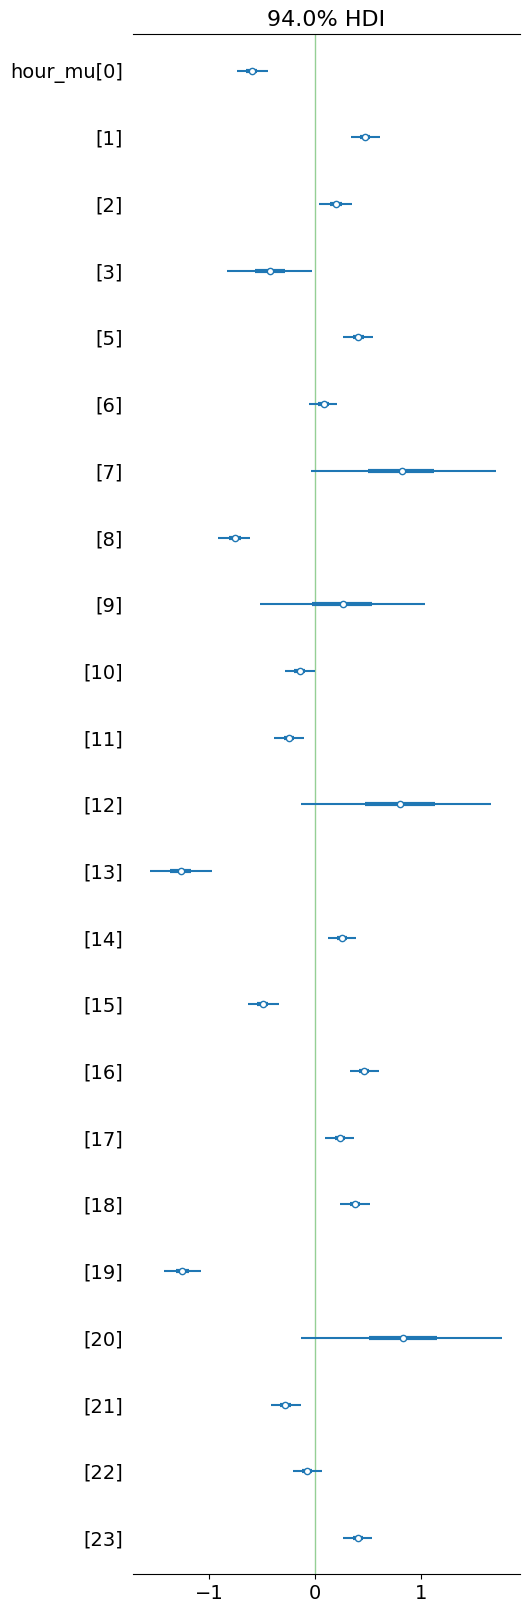

In [159]:
sorted_hour = np.asarray(sorted(hour_strings.astype('int16'))).astype('str')
pm.plot_forest(nc_log_advi_trace, var_names = ['hour_mu'], figsize = (5, 20), rope = (0,0), coords={'hour':sorted_hour})

##### DOY Coefficients

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

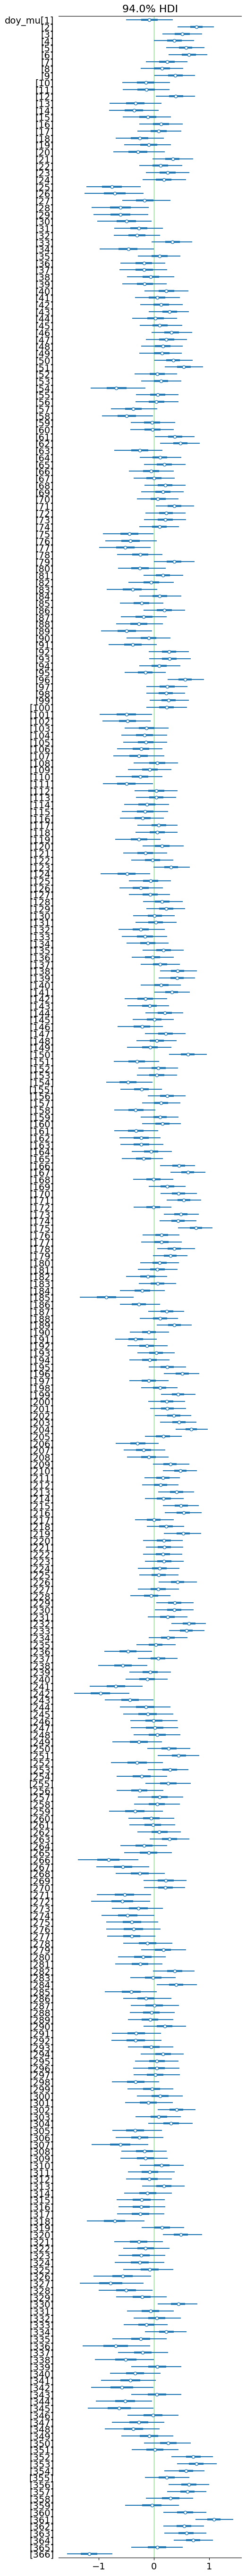

In [160]:
sorted_doy = np.asarray(sorted(dayofyear_strings.astype('int16'))).astype('str')
pm.plot_forest(nc_log_advi_trace, var_names = ['doy_mu'], figsize = (5, 70), rope = (0,0), coords={'day_of_year':sorted_doy})

##### Month Coefficients

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

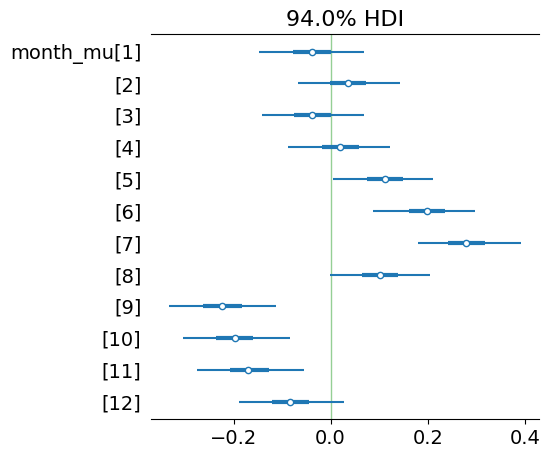

In [161]:
sorted_month = np.asarray(sorted(month_strings.astype('int16'))).astype('str')
pm.plot_forest(nc_log_advi_trace, var_names = ['month_mu'], figsize = (5, 5), rope = (0,0), coords={'month':sorted_month})

##### DOW Coefficients

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

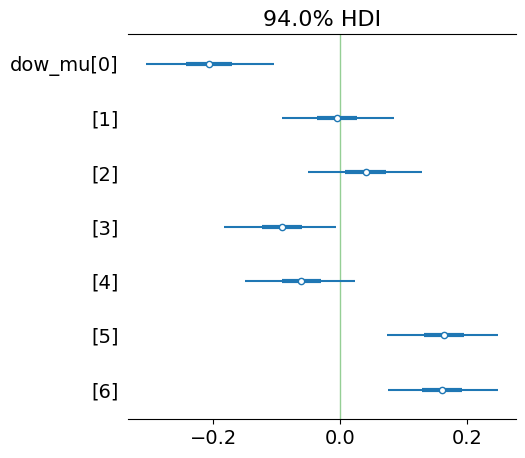

In [162]:
sorted_dow = np.asarray(sorted(weekday_strings.astype('int16'))).astype('str')
pm.plot_forest(nc_log_advi_trace, var_names = ['dow_mu'], figsize = (5, 5), rope = (0,0), coords={'weekday':sorted_dow})

#### Odds Ratio for selected coefficients

Text(0.5, 1.0, 'RIC Origin Odds Ratio with 95% CI')

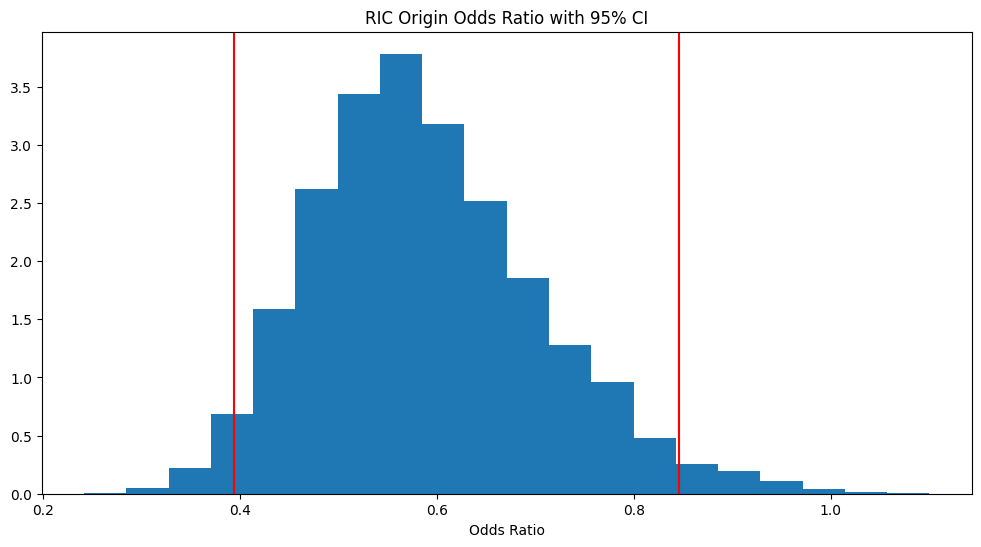

In [163]:
# Origins Odds Ratio
# with 95% CI
origin_string = 'RIC'
bwi_index = list(nc_log_advi_trace.posterior['origin']).index(origin_string)
_, ax = plt.subplots(figsize=(12, 6))
b = nc_log_advi_trace.posterior['origins_beta'][0][:, bwi_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{origin_string} Origin Odds Ratio with 95% CI")

Text(0.5, 1.0, 'ORD Destination Odds Ratio with 95% CI')

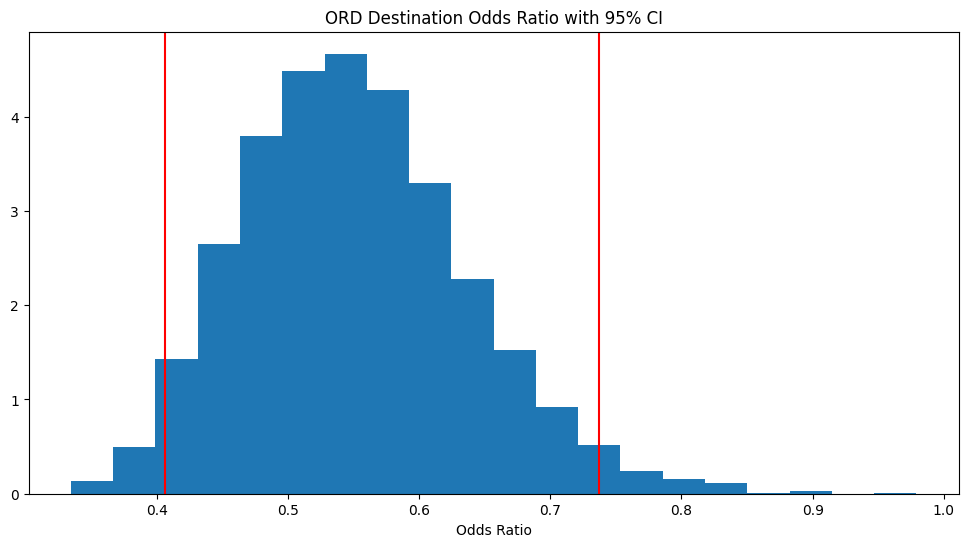

In [164]:
# Destination Odds Ratio
# with 95% CI
origin_string = 'ORD'
bwi_index = list(nc_log_advi_trace.posterior['dest']).index(origin_string)
_, ax = plt.subplots(figsize=(12, 6))
b = nc_log_advi_trace.posterior['dests_beta'][0][:, bwi_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{origin_string} Destination Odds Ratio with 95% CI")

Text(0.5, 1.0, 'ORD Origin Odds Ratio with 95% CI')

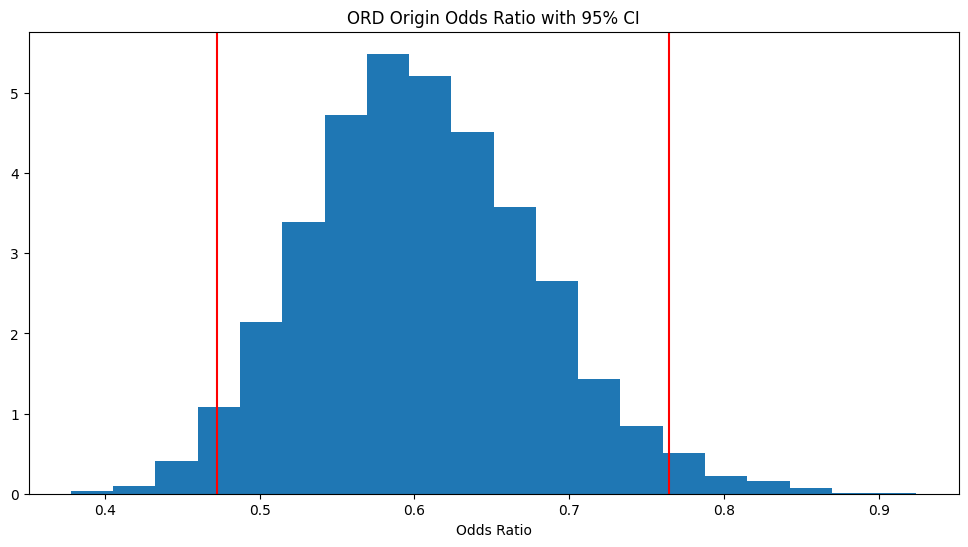

In [165]:
# Origin Odds Ratio
# with 95% CI
origin_string = 'ORD'
bwi_index = list(nc_log_advi_trace.posterior['origin']).index(origin_string)
_, ax = plt.subplots(figsize=(12, 6))
b = nc_log_advi_trace.posterior['origins_beta'][0][:, bwi_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{origin_string} Origin Odds Ratio with 95% CI")

Text(0.5, 1.0, 'LAS Destination Odds Ratio with 95% CI')

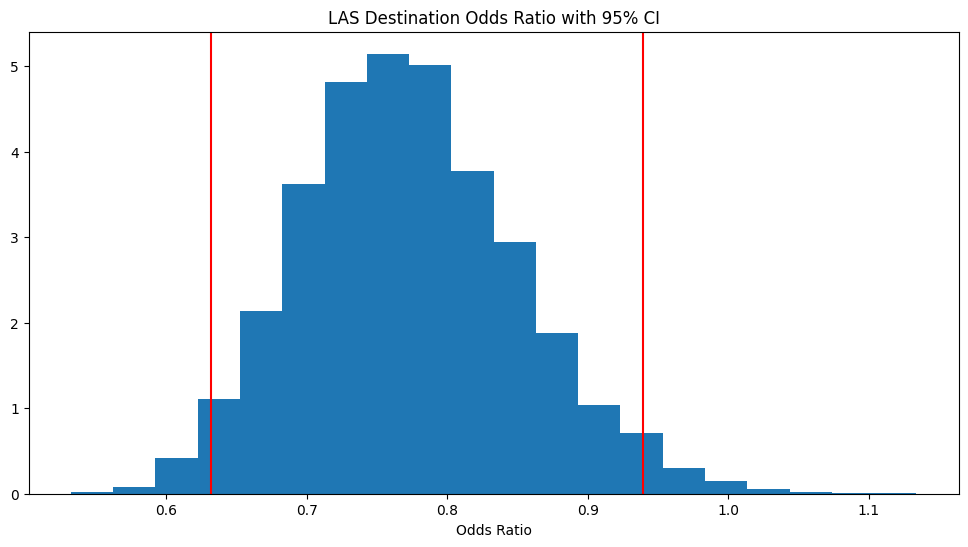

In [166]:
# Destination Odds Ratio
# with 95% CI
origin_string = 'LAS'
bwi_index = list(nc_log_advi_trace.posterior['dest']).index(origin_string)
_, ax = plt.subplots(figsize=(12, 6))
b = nc_log_advi_trace.posterior['dests_beta'][0][:, bwi_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{origin_string} Destination Odds Ratio with 95% CI")

#### Predictions on December 2019

In [167]:
with nc_log_model:
    pm.set_data(
        {
            'TIME':test['index'].to_numpy(),
            'HOUR':test['HOUR'].to_numpy(),
            'DOW':test['DOW'].to_numpy(),
            'DOY':test['DOY'].to_numpy(),
            'MONTH':test['MONTH'].to_numpy(),
            'CARRIER':test.iloc[:,carrier_start:carrier_end].to_numpy(),
            'ORIGIN':test.iloc[:,origin_start:origin_end].to_numpy(),
            'DEST':test.iloc[:, dest_start:dest_end].to_numpy()
        }
    )
    preds = pm.sample_posterior_predictive(
        nc_log_advi_trace, var_names=['p'], random_seed=6040, predictions = True, extend_inferencedata = True, return_inferencedata = True
    )

/Users/ryanlipps/miniconda3/envs/bayesml/lib/python3.11/site-packages/pymc/model/core.py:2021: ShapeWarning: You are resizing a variable with dimension 't' which was initialized as a mutable dimension by another variable ('HOUR'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: []


In [427]:
preds_array = preds.predictions['p'].to_numpy()

In [428]:
test['DELAYED'].value_counts()

DELAYED
0    1382
1     238
Name: count, dtype: int64

In [429]:
test_comps = pd.DataFrame(list(test['DELAYED']), list(preds_array[0][1]))
test_comps = test_comps.reset_index()
test_comps.columns = (['preds', 'actual'])

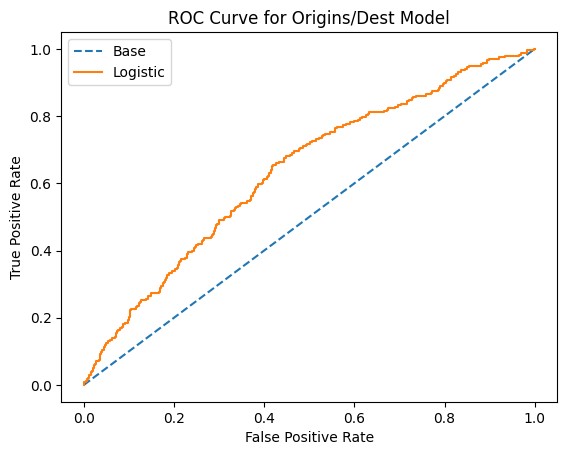

In [430]:
# generate a baseline prediction for comparison
ns_probs = [0 for _ in range(len(test_comps))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_comps['actual'], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_comps['actual'], test_comps['preds'])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Origins/Dest Model')
# show the legend
plt.legend()
# show the plot
plt.show()

##### Confusion matrix with cutoff: 0.1

In [431]:
test_comps['hard_class'] = np.where(test_comps['preds'] > 0.1, 1, 0)
test_comps

preds  actual  hard_class
0     0.126202       0           1
1     0.073757       0           0
2     0.274299       1           1
3     0.165712       0           1
4     0.090181       1           0
...        ...     ...         ...
1615  0.264897       0           1
1616  0.115919       0           1
1617  0.274514       1           1
1618  0.099152       0           0
1619  0.137228       0           1

[1620 rows x 3 columns]

In [432]:
cf = confusion_matrix(test_comps['actual'], test_comps['hard_class'])
cf

array([[591, 791],
       [ 55, 183]])

##### Recall to focus on minimizing false negatives

In [433]:
recall_score = (cf[1][1]) / ((cf[1][1])+(cf[1][0]))
recall_score

0.7689075630252101

##### Area under ROC curve

In [175]:
full_auroc = roc_auc_score(test_comps['actual'], test_comps['hard_class'])
full_auroc

0.5982743314402461

##### Uncertainty for delay probability on training data

Text(0, 0.5, 'P(Delay)')

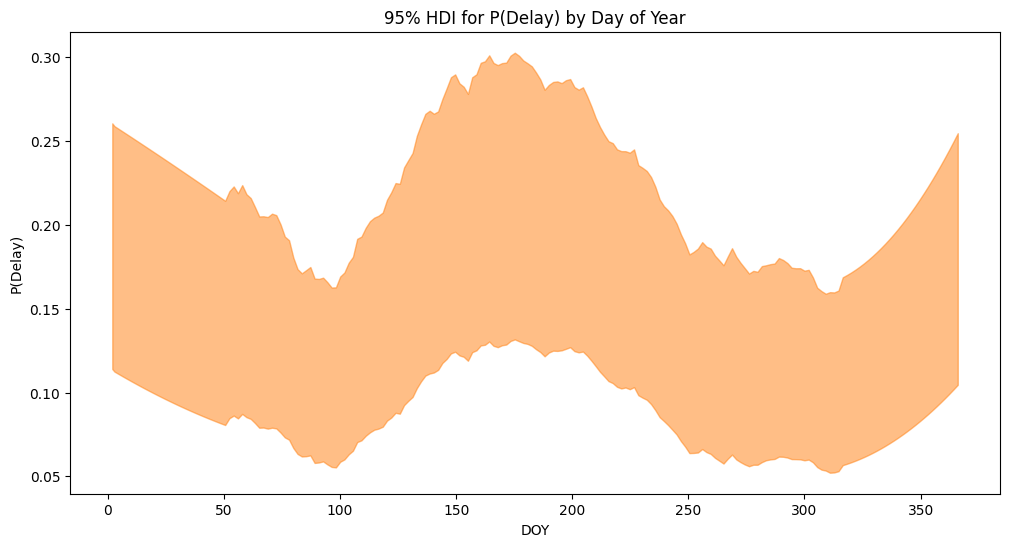

In [176]:
_, ax = plt.subplots(figsize=(12, 6))
rates = nc_log_advi_trace.posterior["p"]
az.plot_hdi(train['DOY'], rates, smooth=True, hdi_prob=0.95)
rate_mean = nc_log_advi_trace.posterior["p"].mean(dim=["draw", "chain"])
ax.set_title("95% HDI for P(Delay) by Day of Year")
ax.set_xlabel("DOY")
ax.set_ylabel('P(Delay)')

Text(0, 0.5, 'P(Delay)')

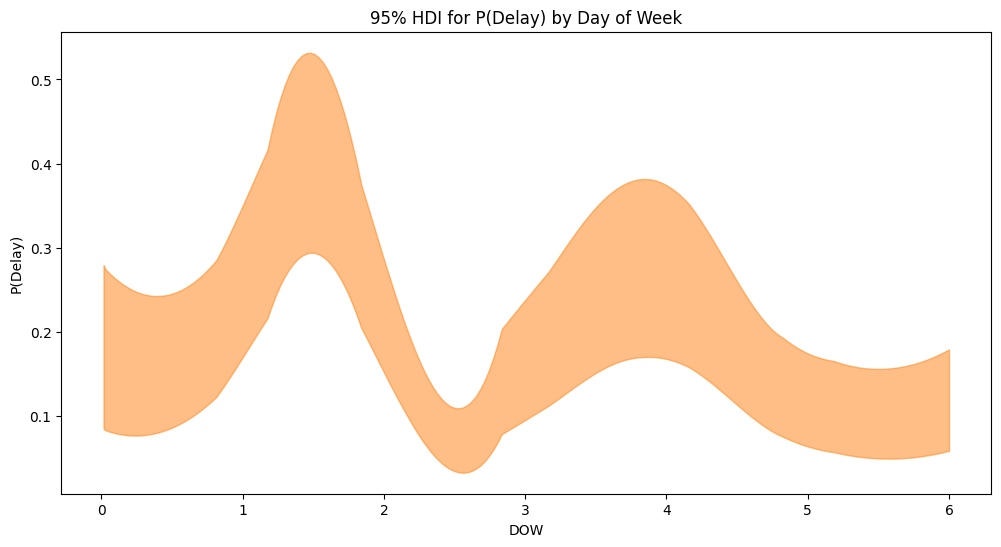

In [177]:
_, ax = plt.subplots(figsize=(12, 6))
rates = nc_log_advi_trace.posterior["p"]
az.plot_hdi(train['DOW'], rates, smooth=True, hdi_prob=0.95)
rate_mean = nc_log_advi_trace.posterior["p"].mean(dim=["draw", "chain"])
ax.set_title("95% HDI for P(Delay) by Day of Week")
ax.set_xlabel("DOW")
ax.set_ylabel('P(Delay)')

Text(0, 0.5, 'P(Delay)')

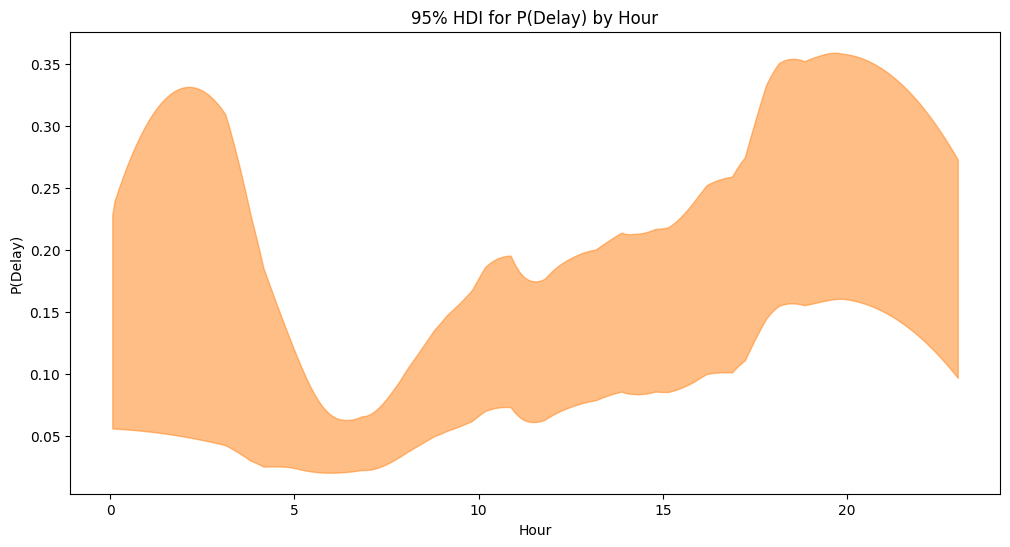

In [178]:
_, ax = plt.subplots(figsize=(12, 6))
rates = nc_log_advi_trace.posterior["p"]
az.plot_hdi(train['HOUR'], rates, smooth=True, hdi_prob=0.95)
ax.set_title("95% HDI for P(Delay) by Hour")
ax.set_xlabel("Hour")
ax.set_ylabel('P(Delay)')

Text(0, 0.5, 'P(Delay)')

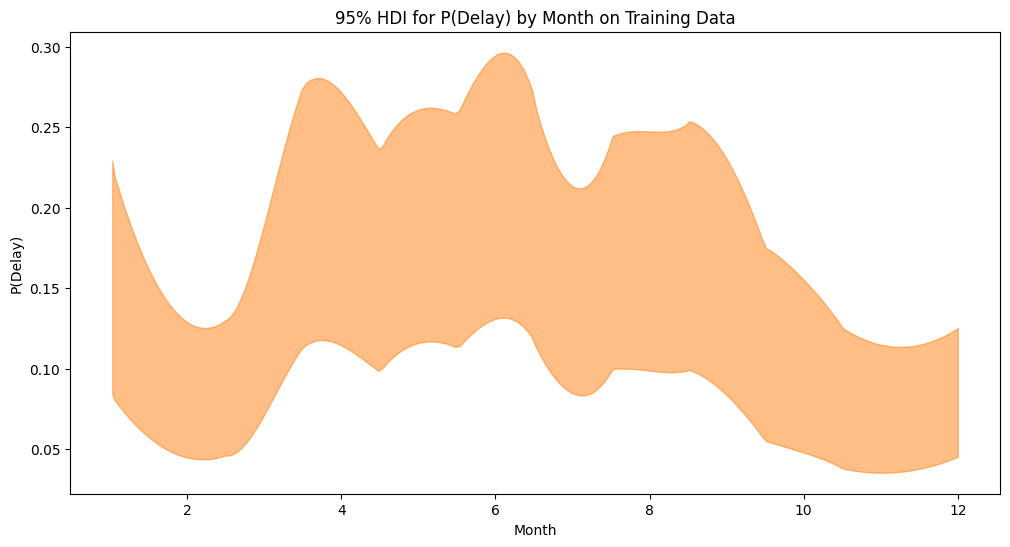

In [434]:
_, ax = plt.subplots(figsize=(12, 6))
rates = nc_log_advi_trace.posterior["p"]
az.plot_hdi(train['MONTH'], rates, smooth=True, hdi_prob=0.95)
rate_mean = nc_log_advi_trace.posterior["p"].mean(dim=["draw", "chain"])
ax.set_title("95% HDI for P(Delay) by Month on Training Data")
ax.set_xlabel("Month")
ax.set_ylabel('P(Delay)')

##### Uncertainty for delay probability for test data

Text(0, 0.5, 'P(Delay)')

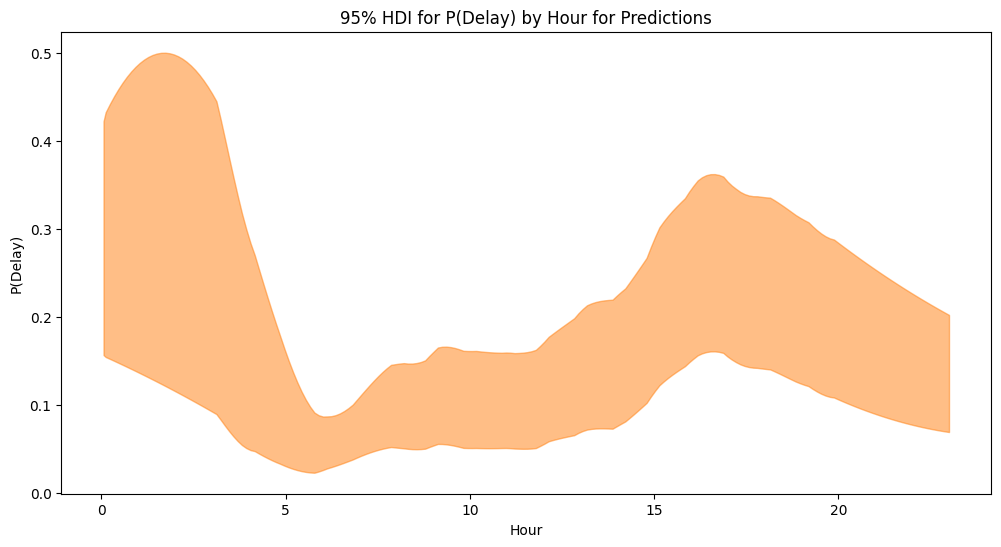

In [193]:
_, ax = plt.subplots(figsize=(12, 6))
rates = preds.predictions["p"]
az.plot_hdi(test['HOUR'], rates, smooth=True, hdi_prob=0.95)
ax.set_title("95% HDI for P(Delay) by Hour for Predictions")
ax.set_xlabel("Hour")
ax.set_ylabel('P(Delay)')

Text(0, 0.5, 'P(Delay)')

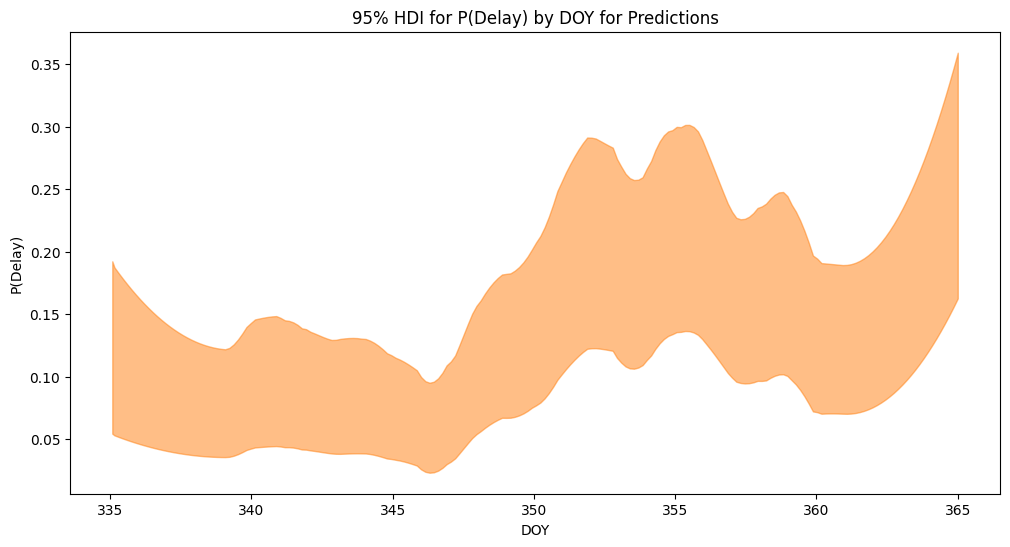

In [196]:
_, ax = plt.subplots(figsize=(12, 6))
rates = preds.predictions["p"]
az.plot_hdi(test['DOY'], rates, smooth=True, hdi_prob=0.95)
ax.set_title("95% HDI for P(Delay) by DOY for Predictions")
ax.set_xlabel("DOY")
ax.set_ylabel('P(Delay)')

Text(0, 0.5, 'P(Delay)')

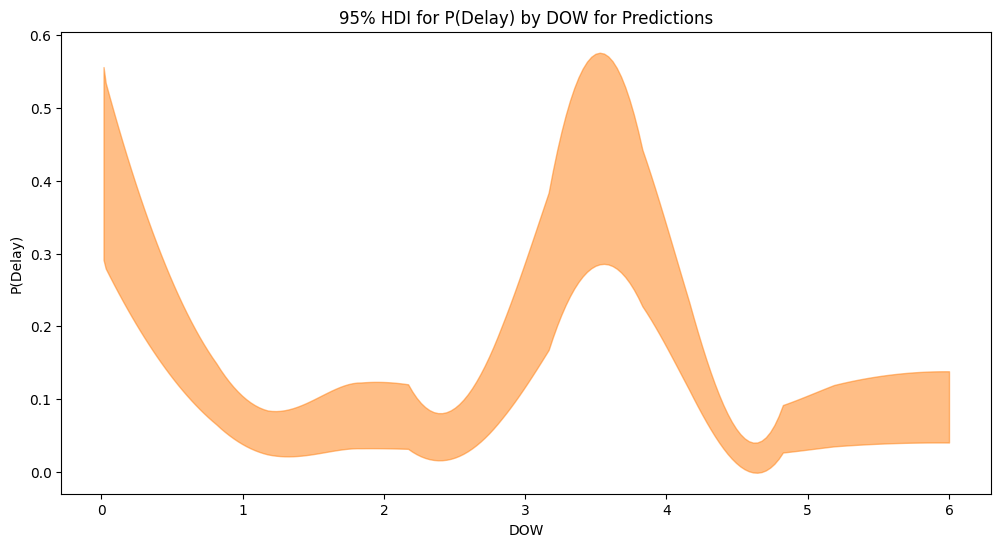

In [197]:
_, ax = plt.subplots(figsize=(12, 6))
rates = preds.predictions["p"]
az.plot_hdi(test['DOW'], rates, smooth=True, hdi_prob=0.95)
ax.set_title("95% HDI for P(Delay) by DOW for Predictions")
ax.set_xlabel("DOW")
ax.set_ylabel('P(Delay)')

#### Analysis of Carrier Model

In [180]:
c_log_prior_pred = pm.sample_prior_predictive(samples = 100, model = carrier_log_model, random_seed = 6040) 

Sampling: [Y1, carriers_beta, dow_mu_raw, doy_mu_raw, hour_mu_raw, intercept, month_mu_raw]


<Axes: >

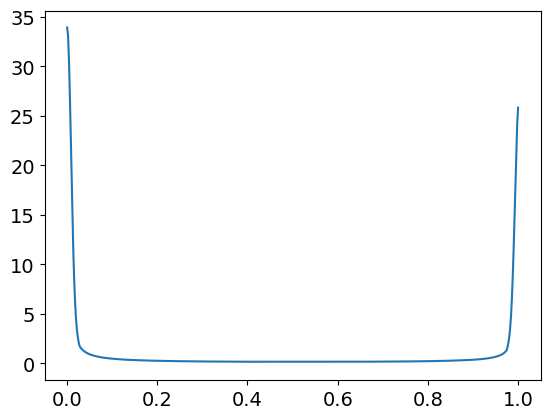

In [181]:
az.plot_dist(c_log_prior_pred.prior['p'])

#### Posterior predictive performance

In [182]:
c_log_post_pred = pm.sample_posterior_predictive(carrier_log_advi_trace, model = carrier_log_model, random_seed = 6040, return_inferencedata = True)

Sampling: [Y1]


<Axes: xlabel='Y1 / Y1'>

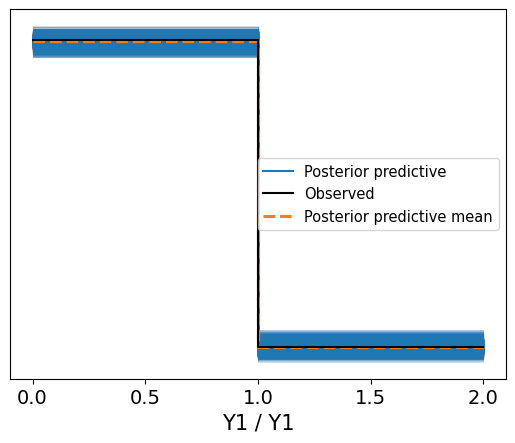

In [183]:
az.plot_ppc(c_log_post_pred)

##### Bayesian P-Value

(0.9, 1.1)

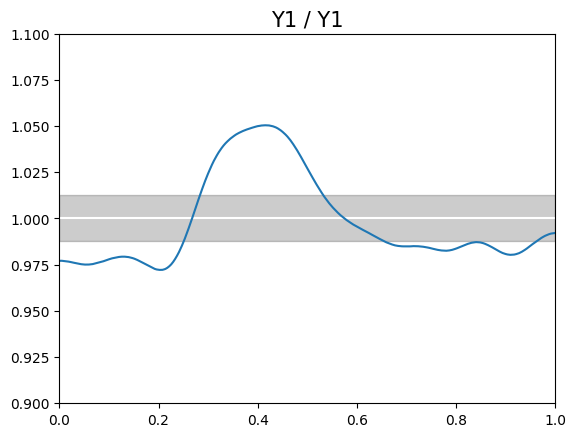

In [184]:
ax = az.plot_bpv(c_log_post_pred)
ax.set_ylim([0.9, 1.1])

#### Coefficients analysis

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

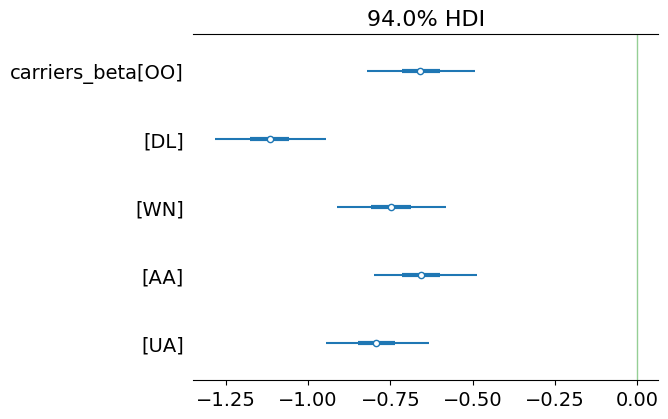

In [185]:
pm.plot_forest(carrier_log_advi_trace, var_names = ['carriers_beta'], rope = (0,0))

Text(0.5, 1.0, 'OO Carrier Odds Ratio with 95% CI')

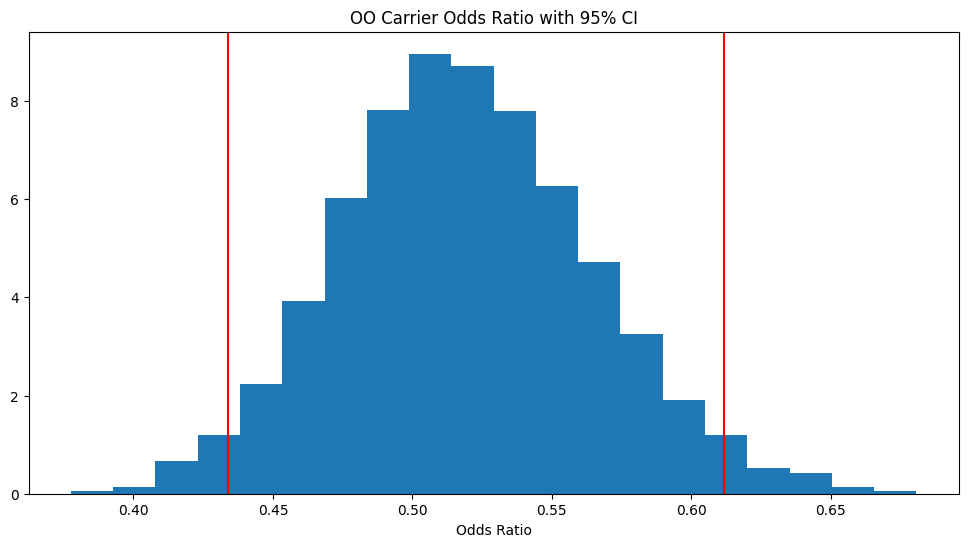

In [186]:
# Origins Odds Ratio
# with 95% CI
carrier_string = 'OO'
carrier_index = list(carrier_log_advi_trace.posterior['carrier']).index(carrier_string)
_, ax = plt.subplots(figsize=(12, 6))
b = carrier_log_advi_trace.posterior['carriers_beta'][0][:, carrier_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{carrier_string} Carrier Odds Ratio with 95% CI")

Text(0.5, 1.0, 'UA Carrier Odds Ratio with 95% CI')

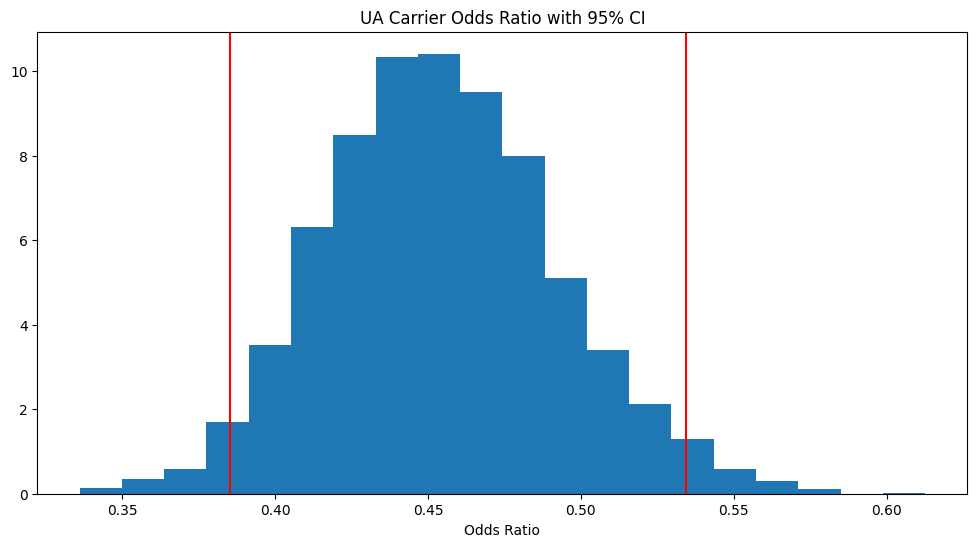

In [187]:
# Origins Odds Ratio
# with 95% CI
carrier_string = 'UA'
carrier_index = list(carrier_log_advi_trace.posterior['carrier']).index(carrier_string)
_, ax = plt.subplots(figsize=(12, 6))
b = carrier_log_advi_trace.posterior['carriers_beta'][0][:, carrier_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{carrier_string} Carrier Odds Ratio with 95% CI")

Text(0.5, 1.0, 'DL Carrier Odds Ratio with 95% CI')

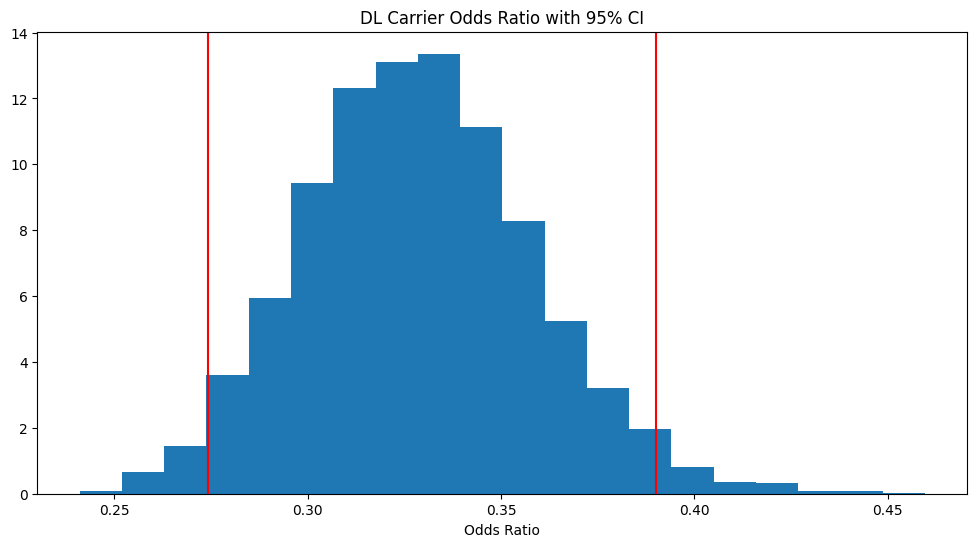

In [188]:
# Origins Odds Ratio
# with 95% CI
carrier_string = 'DL'
carrier_index = list(carrier_log_advi_trace.posterior['carrier']).index(carrier_string)
_, ax = plt.subplots(figsize=(12, 6))
b = carrier_log_advi_trace.posterior['carriers_beta'][0][:, carrier_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{carrier_string} Carrier Odds Ratio with 95% CI")

Text(0.5, 1.0, 'AA Carrier Odds Ratio with 95% CI')

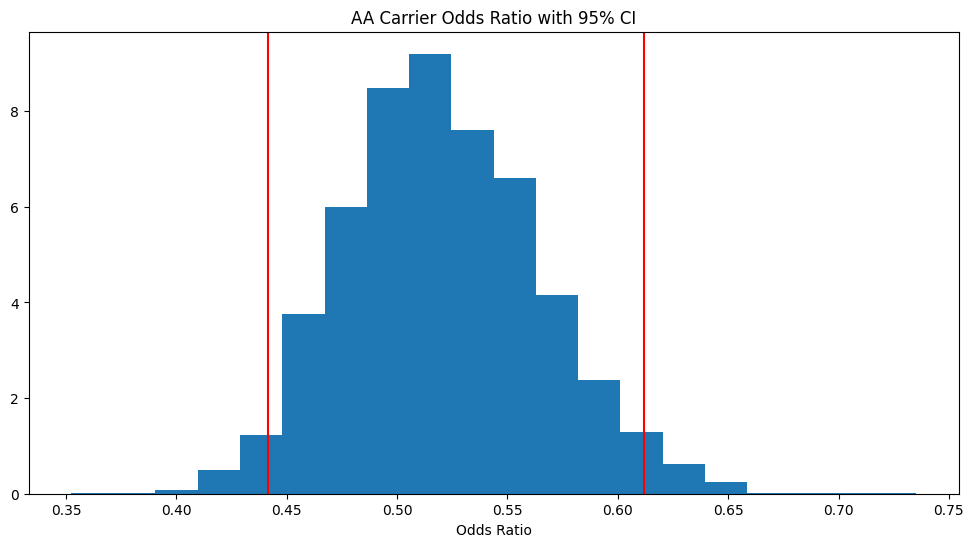

In [189]:
# Origins Odds Ratio
# with 95% CI
carrier_string = 'AA'
carrier_index = list(carrier_log_advi_trace.posterior['carrier']).index(carrier_string)
_, ax = plt.subplots(figsize=(12, 6))
b = carrier_log_advi_trace.posterior['carriers_beta'][0][:, carrier_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{carrier_string} Carrier Odds Ratio with 95% CI")

Text(0.5, 1.0, 'WN Carrier Odds Ratio with 95% CI')

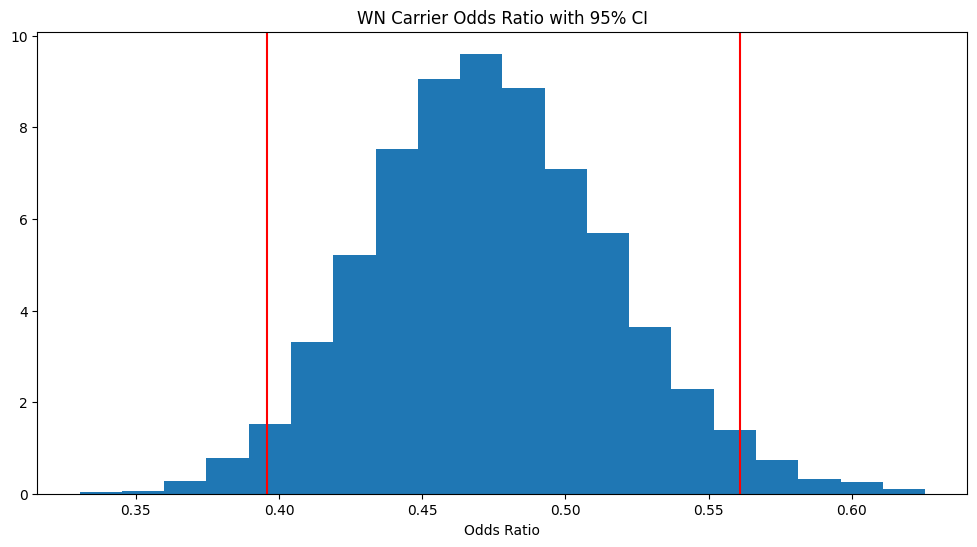

In [190]:
# Origins Odds Ratio
# with 95% CI
carrier_string = 'WN'
carrier_index = list(carrier_log_advi_trace.posterior['carrier']).index(carrier_string)
_, ax = plt.subplots(figsize=(12, 6))
b = carrier_log_advi_trace.posterior['carriers_beta'][0][:, carrier_index]
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
plt.hist(np.exp(b), bins=20, density=True)
plt.axvline(np.exp(lb), color = 'r')
plt.axvline(np.exp(ub), color = 'r')
plt.xlabel("Odds Ratio")
plt.title(f"{carrier_string} Carrier Odds Ratio with 95% CI")

#### Predictions on December 2019

In [209]:
with carrier_log_model:
    pm.set_data(
        {
            'TIME':test['index'].to_numpy(),
            'HOUR':test['HOUR'].to_numpy(),
            'DOW':test['DOW'].to_numpy(),
            'DOY':test['DOY'].to_numpy(),
            'MONTH':test['MONTH'].to_numpy(),
            'CARRIER':test.iloc[:,carrier_start:carrier_end].to_numpy(),
            'ORIGIN':test.iloc[:,origin_start:origin_end].to_numpy(),
            'DEST':test.iloc[:, dest_start:dest_end].to_numpy()
        }
    )
    carrier_preds = pm.sample_posterior_predictive(
        carrier_log_advi_trace, var_names=['p'], random_seed=6040, predictions = True, extend_inferencedata = True, return_inferencedata = True
    )

/Users/ryanlipps/miniconda3/envs/bayesml/lib/python3.11/site-packages/pymc/model/core.py:2021: ShapeWarning: You are resizing a variable with dimension 't' which was initialized as a mutable dimension by another variable ('HOUR'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: []


In [210]:
carrier_preds_array = carrier_preds.predictions['p'].to_numpy()

In [211]:
carrier_test_comps = pd.DataFrame(list(test['DELAYED']), list(preds_array[0][1]))
carrier_test_comps = carrier_test_comps.reset_index()
carrier_test_comps.columns = (['preds', 'actual'])

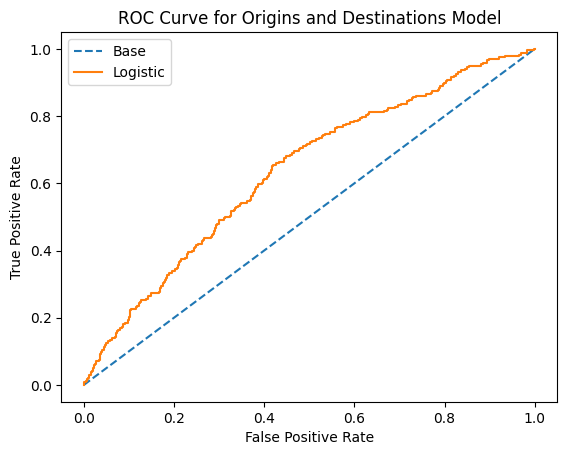

In [212]:
# generate a baseline prediction for comparison
ns_probs = [0 for _ in range(len(carrier_test_comps))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(carrier_test_comps['actual'], ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(carrier_test_comps['actual'], carrier_test_comps['preds'])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Origins and Destinations Model')
# show the legend
plt.legend()
# show the plot
plt.show()

##### Confusion matrix with cutoff: 0.1

In [217]:
carrier_test_comps['hard_class'] = np.where(carrier_test_comps['preds'] > 0.1, 1, 0)

In [425]:
carrier_cf = confusion_matrix(carrier_test_comps['actual'], carrier_test_comps['hard_class'])
carrier_cf

array([[591, 791],
       [ 55, 183]])

##### Recall to focus on minimizing false negatives

In [426]:
recall_score = (carrier_cf[1][1]) / ((carrier_cf[1][1])+(carrier_cf[1][0]))
recall_score

0.7689075630252101

##### Area under ROC curve

In [216]:
full_auroc = roc_auc_score(carrier_test_comps['actual'], carrier_test_comps['hard_class'])
full_auroc

0.5982743314402461